# **Clustering Techniques**

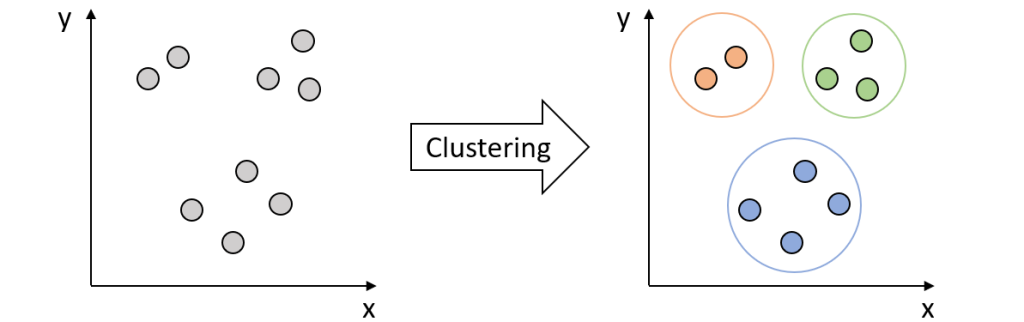

Clustering is a fundamental technique in unsupervised machine learning that aims to group similar data points together based on their inherent characteristics. Unlike supervised learning, which relies on labeled data, clustering algorithms explore the structure of the data to identify patterns and relationships without predefined categories.

This notebook delves into various clustering methodologies, including **KMeans**, **Agglomerative Clustering**, and **DBSCAN**, among others. Each technique has its strengths and weaknesses, making it essential to understand the context and nature of the data when choosing the appropriate clustering method.

To enhance our understanding, we will employ visualizations such as dendrograms and silhouette scores, which provide valuable insights into the effectiveness of the clustering process and help determine the optimal number of clusters. Additionally, we will leverage Principal Component Analysis (PCA) to reduce the dimensionality of our data, allowing for a clearer interpretation of the clusters formed.

By the end of this notebook, readers will have a comprehensive overview of different clustering techniques, their applications, and insights into how to evaluate and interpret clustering results effectively. Whether you're a data scientist, analyst, or enthusiast, this exploration of clustering techniques will equip you with the knowledge and tools necessary to analyze complex datasets.

## **Table of Contents 📃**
* Import and Read the Dataset
* EDA
  - Rename the Columns
  - Numerical EDA
  - Visual EDA
    * Univariate
    * Bivariate
    * Multivariate
* Feature Engineering
* Clustering
    * Helper Functions for Identifying the Number of Clusters
    1. Kmeans
    2. Kmeans with PCA
    3. Hierchical Clustering
    4. DBSCAN
    5. Affinity Propagation
    6. Mean Shift
    7. OPTICS
* Conclusion

# **Import and Read the Dataset**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, estimate_bandwidth, OPTICS, DBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

from itertools import product
from scipy.stats import pearsonr
import itertools

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [4]:
df = pd.read_csv('/content/Customers_Data.csv')
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

# **I. EDA**



### **a. Rename the Columns**

In [5]:
df.rename(columns={'CustomerID':'customer_id',
                   'Gender':'gender',
                   'Age':'age',
                   'Annual Income (k$)':'annual_income',
                   'Spending Score (1-100)':'spending_score'
                    }, inplace=True)
df.columns

Index(['customer_id', 'gender', 'age', 'annual_income', 'spending_score'], dtype='object')

### **b. Numerical EDA**

In [6]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n'
      f'Dimension : {df.ndim}')

Shape     : (200, 5)
Size      : 1000
Dimension : 2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.describe().T

count    mean        std   min    25%    50%     75%    max
customer_id     200.0  100.50  57.879185   1.0  50.75  100.5  150.25  200.0
age             200.0   38.85  13.969007  18.0  28.75   36.0   49.00   70.0
annual_income   200.0   60.56  26.264721  15.0  41.50   61.5   78.00  137.0
spending_score  200.0   50.20  25.823522   1.0  34.75   50.0   73.00   99.0

In [9]:
print(f'Total duplicated: {sum(df.duplicated())}')

Total duplicated: 0


In [10]:
def get_unique_values(dataframe):
    output_data = []

    for col in dataframe.columns:
        if dataframe.loc[:, col].nunique() <= 10:
            unique_values = dataframe.loc[:, col].unique()
            output_data.append([col, dataframe.loc[:, col].nunique(), unique_values, dataframe.loc[:, col].dtype])
        else:
            output_data.append([col, dataframe.loc[:, col].nunique(),"-", dataframe.loc[:, col].dtype])
    output_dataframe = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_dataframe
get_unique_values(df)

Column Name  Number of Unique Values  Unique Values  Data Type
0     customer_id                      200               -     int64
1          gender                        2  [Male, Female]    object
2             age                       51               -     int64
3   annual_income                       64               -     int64
4  spending_score                       84               -     int64

In [11]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include='number').columns
num_cols = num_cols.drop('customer_id');

In [12]:
df[num_cols].skew()

age               0.485569
annual_income     0.321843
spending_score   -0.047220
dtype: float64

### **c. Visual EDA**

#### **c.1. Univariate**

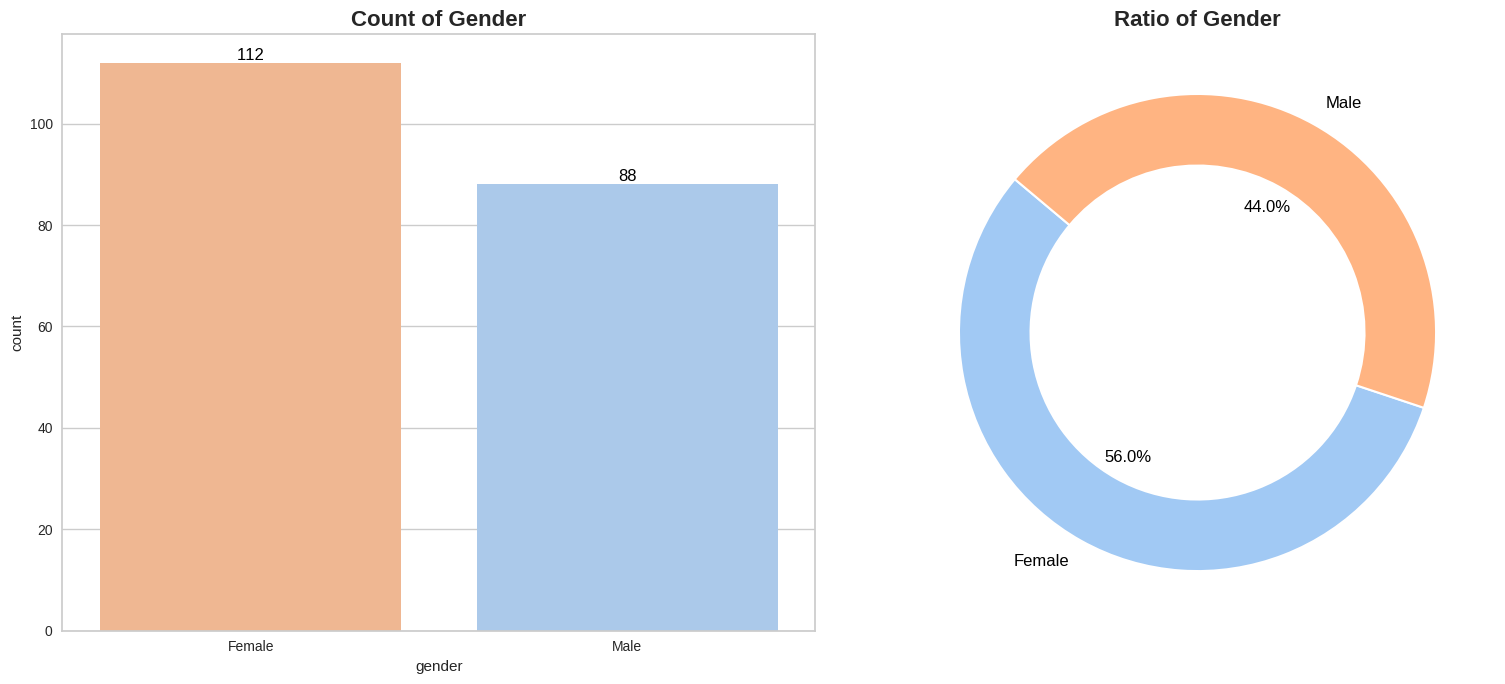

In [13]:
def plot_categorical_analysis(df, column):
    palette = sns.color_palette('pastel', n_colors=len(df[column].unique()))

    fig, axs = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 1]})

    # Countplot
    sns.countplot(data=df,
                  x=column,
                  hue=column,
                  ax=axs[0],
                  order=df[column].value_counts().index,
                  palette=palette)

    for container in axs[0].containers:
        axs[0].bar_label(container, fontsize=12, color='black')

    axs[0].set_title(f"Count of {column.capitalize()}", fontsize=16, fontweight='bold')

    # Donut Plot
    counts = df[column].value_counts()
    wedges, texts, autotexts = axs[1].pie(counts,
                                          labels=counts.index,
                                          autopct='%1.1f%%',
                                          startangle=140,
                                          colors=palette,
                                          wedgeprops=dict(width=0.3, edgecolor='w', linewidth=1.5),
                                          textprops=dict(color='black', fontsize=12))

    center_circle = plt.Circle((0, 0), 0.25, fc='white', edgecolor='w', linewidth=1.5)
    axs[1].add_artist(center_circle)
    axs[1].set_title(f"Ratio of {column.capitalize()}", fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


for column in cat_cols:
    plot_categorical_analysis(df, column)

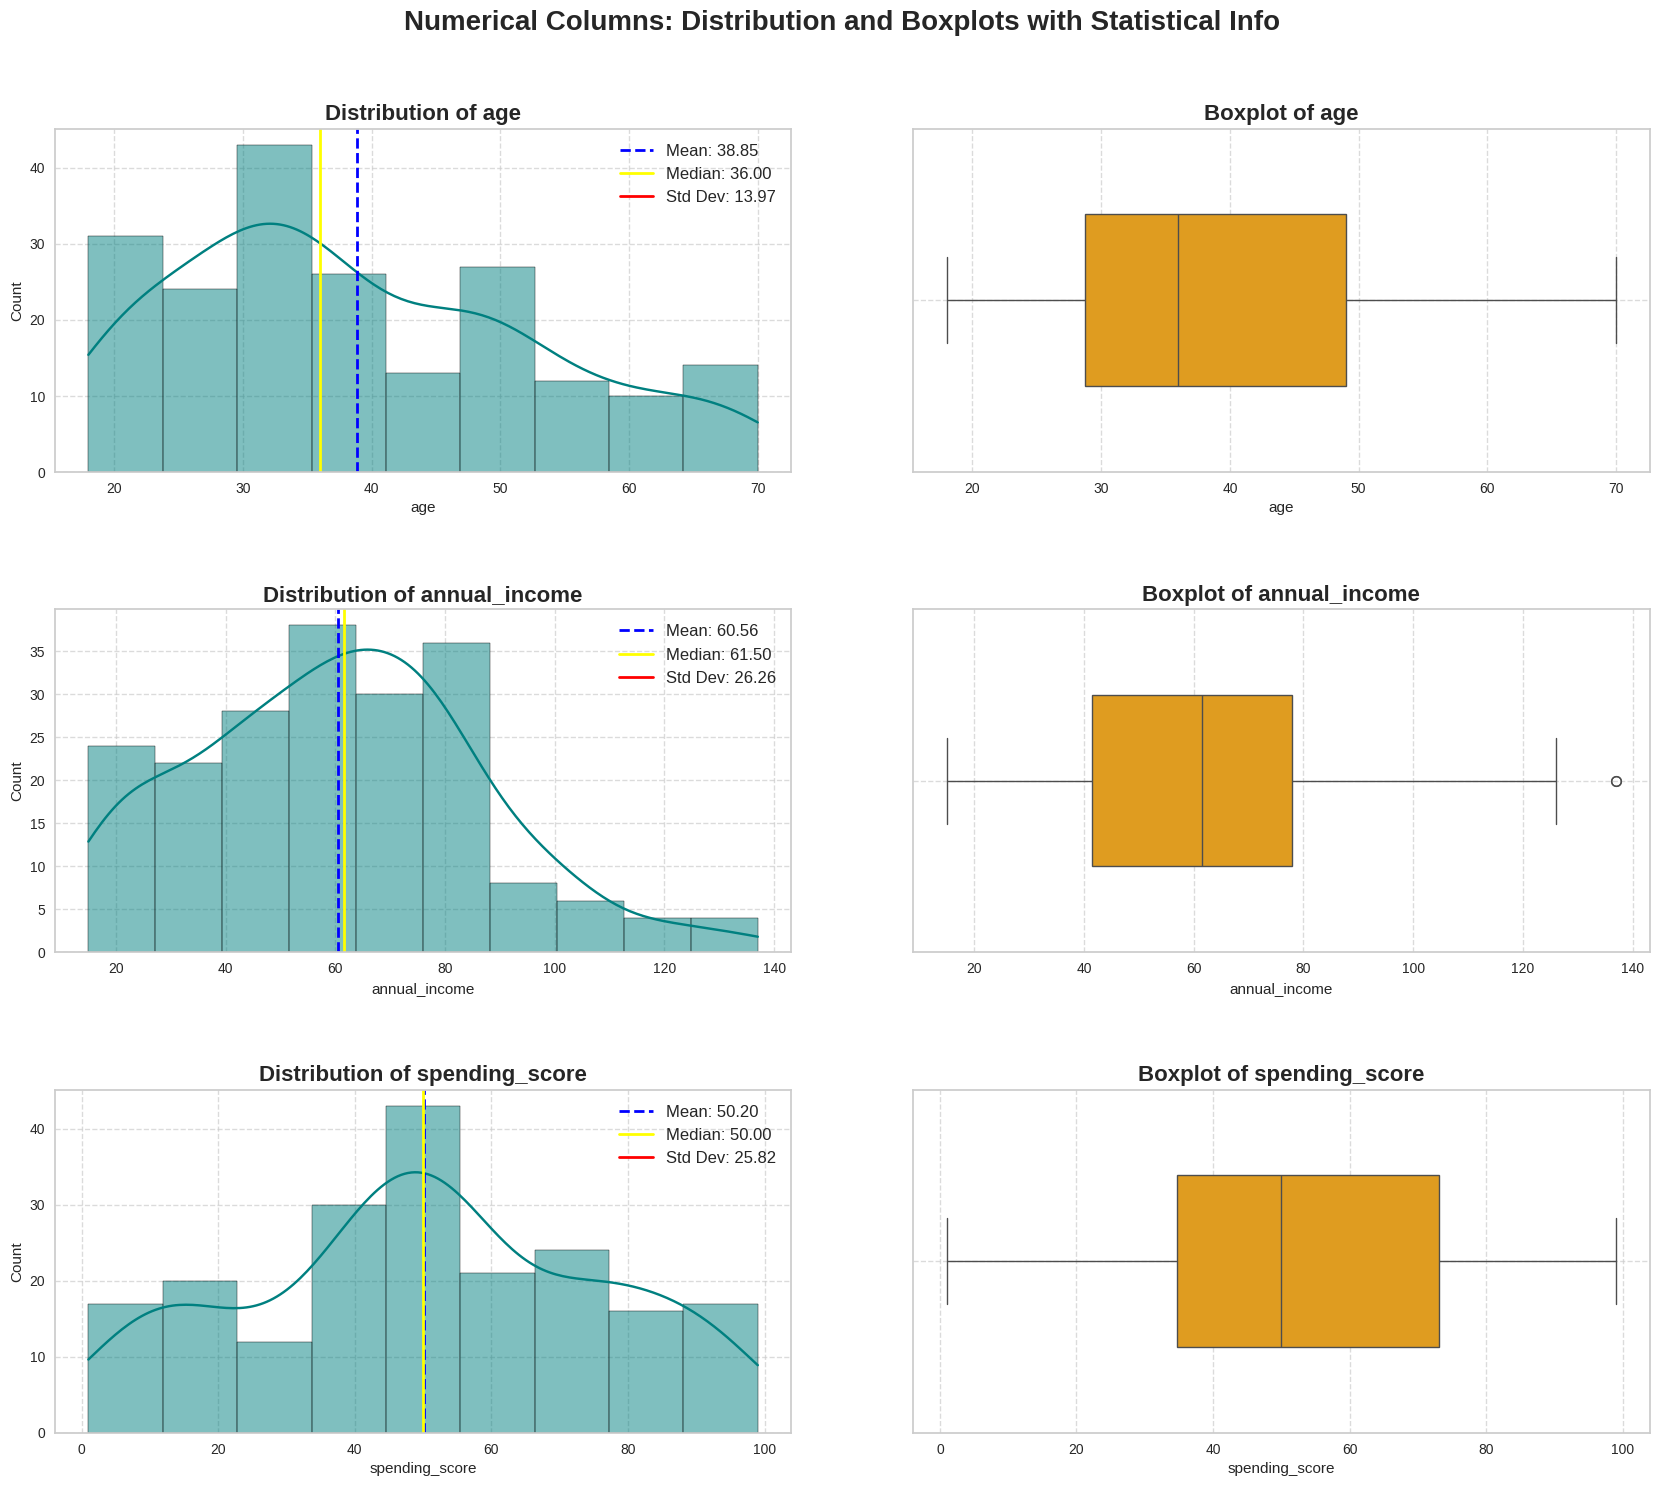

In [14]:
from matplotlib.lines import Line2D


def plot_numerical_analysis(df, num_cols, dist_color='teal', box_color='orange', figsize=(18, 5)):
    # Calculate layout for subplots: 2 columns layout (distribution plot + boxplot for each numeric column)
    n = len(num_cols)
    n_cols = 2  # 2 columns (Distribution + Boxplot)
    n_rows = n  # Each numeric column will occupy one row with two subplots

    # Create subplots with dynamic sizing based on the number of rows
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    fig.tight_layout(pad=5.0)

    # Loop over numeric columns
    for i, col in enumerate(num_cols):
        # Distribution plot with KDE
        sns.histplot(df[col], kde=True, ax=axes[i, 0], color=dist_color)
        axes[i, 0].set_title(f'Distribution of {col}', fontsize=16, fontweight='bold')
        axes[i, 0].grid(True, linestyle='--', alpha=0.7)

        # Calculate statistics
        mean_val = df[col].mean()
        median_val = df[col].median()
        std_val = df[col].std()

        # Annotate statistics on the distribution plot
        axes[i, 0].axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[i, 0].axvline(median_val, color='yellow', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
        # Manually create legend with correct colors for mean, median, and std dev
        legend_elements = [
            Line2D([0], [0], color='blue', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}'),
            Line2D([0], [0], color='yellow', linestyle='-', lw=2, label=f'Median: {median_val:.2f}'),
            Line2D([0], [0], color='red', linestyle='-', lw=2, label=f'Std Dev: {std_val:.2f}')
        ]
        axes[i, 0].legend(handles=legend_elements, loc='upper right', fontsize=12)
        # Boxplot
        sns.boxplot(data=df, x=col, ax=axes[i, 1], color=box_color, width=0.5)
        axes[i, 1].set_title(f'Boxplot of {col}', fontsize=16, fontweight='bold')
        axes[i, 1].grid(True, linestyle='--', alpha=0.7)

        # Add overall padding between subplots for clarity
        plt.subplots_adjust(hspace=0.4)

    # Add a global title for the entire figure
    fig.suptitle('Numerical Columns: Distribution and Boxplots with Statistical Info',
                 fontsize=20, fontweight='bold', y=1.02)

    # Show the plot
    plt.show()



plot_numerical_analysis(df, num_cols)

#### **c.2. Bivariate**

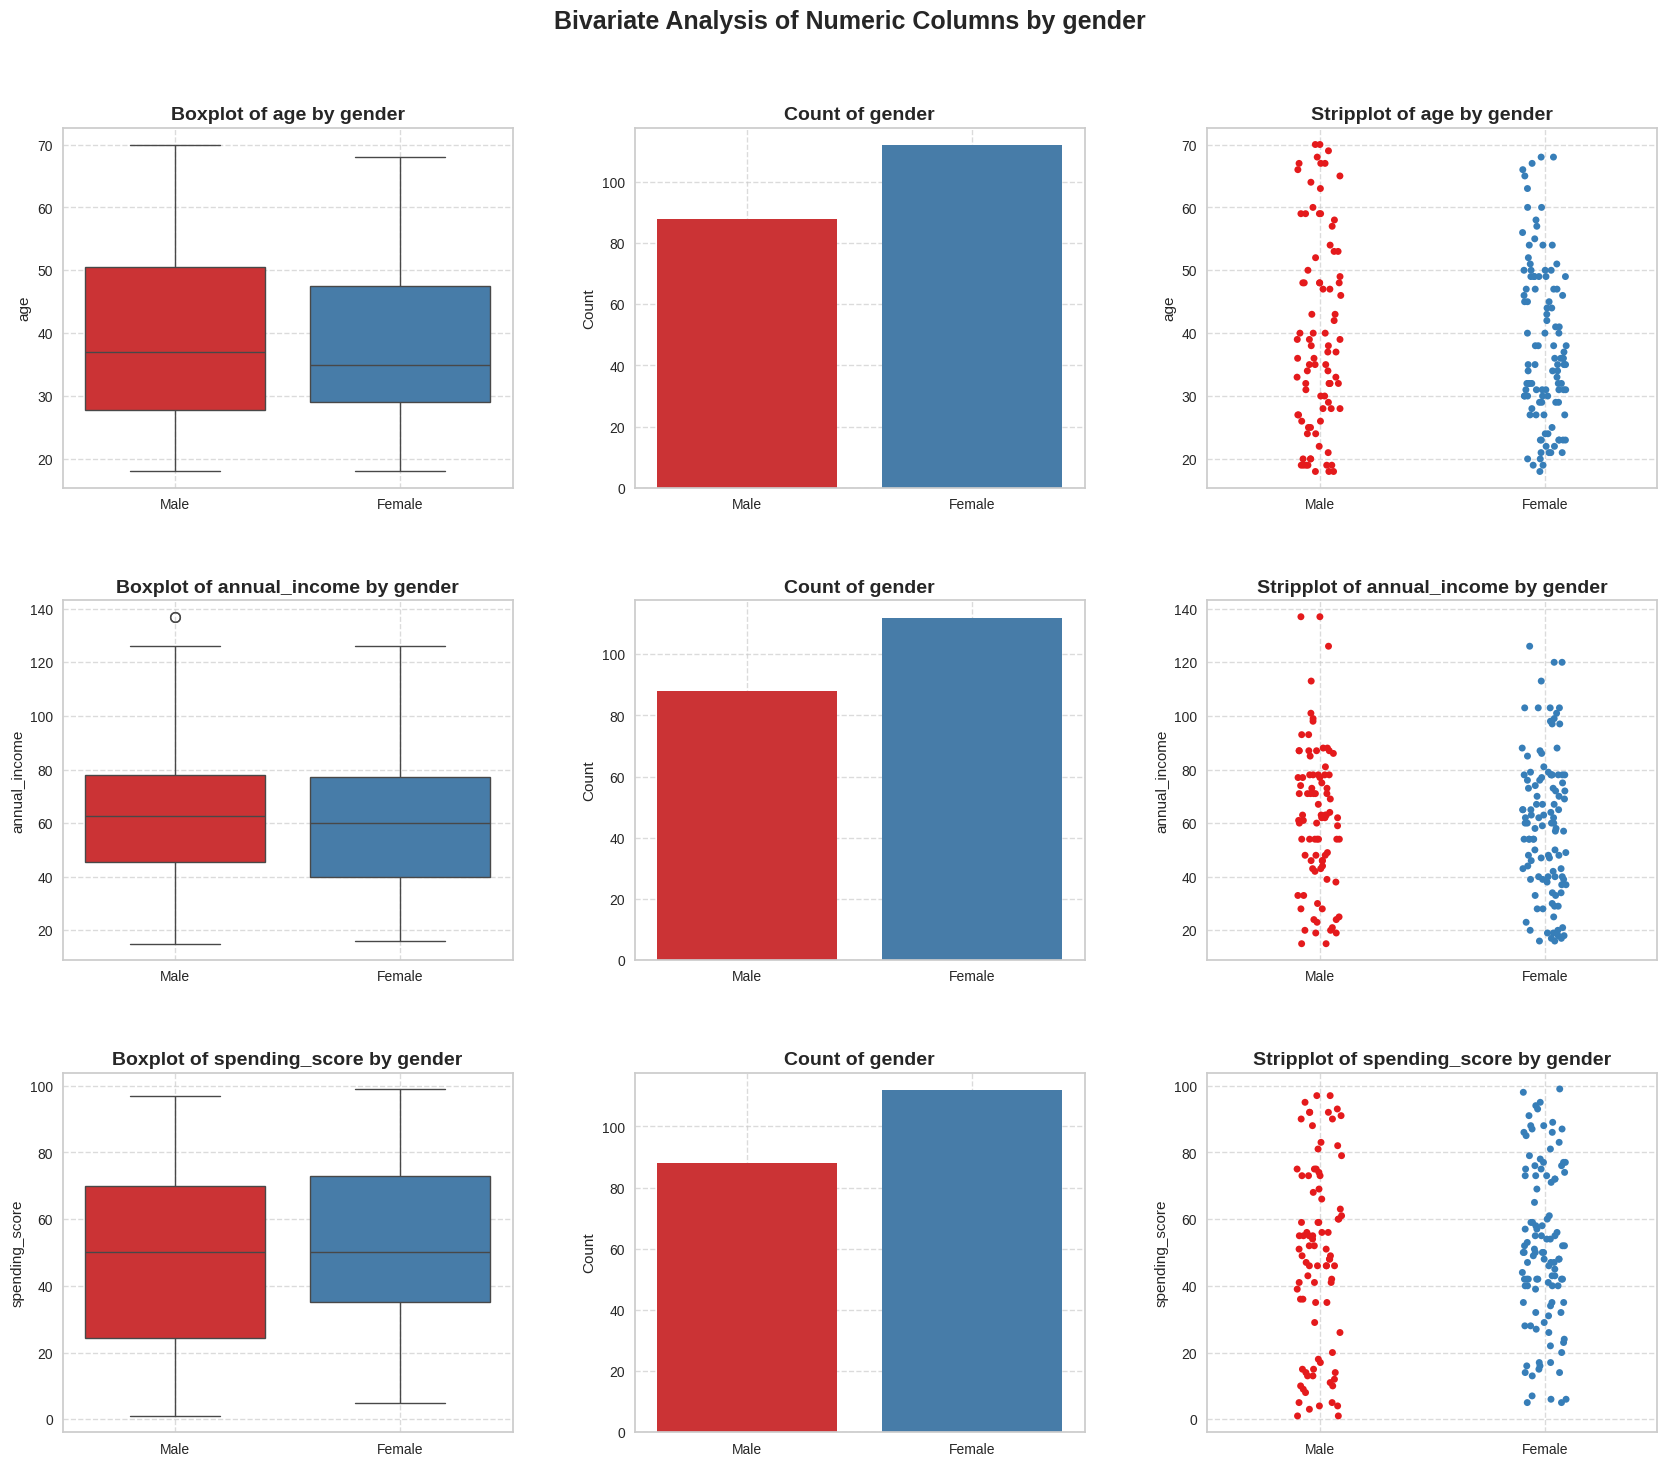

In [15]:
def plot_bivariate_analysis(df, num_cols, cat_col='gender', figsize=(18, 5)):
    """
    Create a grid of plots to analyze bivariate relationships between numeric columns and a categorical column.

    Parameters:
    - df: DataFrame containing the data.
    - num_cols: List of numeric column names to analyze.
    - cat_col: Categorical column name for comparison.
    - figsize: Size of the entire figure.
    """
    # Calculate layout for subplots: 3 columns layout (Boxplot, Countplot, Stripplot)
    n = len(num_cols)
    n_cols = 3  # 3 columns (Boxplot, Countplot, Stripplot)
    n_rows = n  # Each numeric column will occupy one row with three subplots

    # Create subplots with dynamic sizing based on the number of rows
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    fig.tight_layout(pad=5.0)

    # Loop over numeric columns
    for i, col in enumerate(num_cols):
        # Boxplot
        sns.boxplot(data=df, x=cat_col, y=col, hue=cat_col, ax=axes[i, 0], palette='Set1')
        axes[i, 0].set_title(f'Boxplot of {col} by {cat_col}', fontsize=14, fontweight='bold')
        axes[i, 0].set_xlabel('')
        axes[i, 0].set_ylabel(col)
        axes[i, 0].grid(True, linestyle='--', alpha=0.7)

        # Countplot
        sns.countplot(data=df, x=cat_col, hue=cat_col, ax=axes[i, 1], palette='Set1')
        axes[i, 1].set_title(f'Count of {cat_col}', fontsize=14, fontweight='bold')
        axes[i, 1].set_xlabel('')
        axes[i, 1].set_ylabel('Count')
        axes[i, 1].grid(True, linestyle='--', alpha=0.7)

        # Stripplot
        sns.stripplot(data=df, x=cat_col, hue=cat_col, y=col, ax=axes[i, 2], palette='Set1', jitter=True)
        axes[i, 2].set_title(f'Stripplot of {col} by {cat_col}', fontsize=14, fontweight='bold')
        axes[i, 2].set_xlabel('')
        axes[i, 2].set_ylabel(col)
        axes[i, 2].grid(True, linestyle='--', alpha=0.7)

    # Add a global title for the entire figure
    fig.suptitle(f'Bivariate Analysis of Numeric Columns by {cat_col}', fontsize=18, fontweight='bold', y=1.02)

    # Show the plot
    plt.show()

# Example usage
plot_bivariate_analysis(df, num_cols)

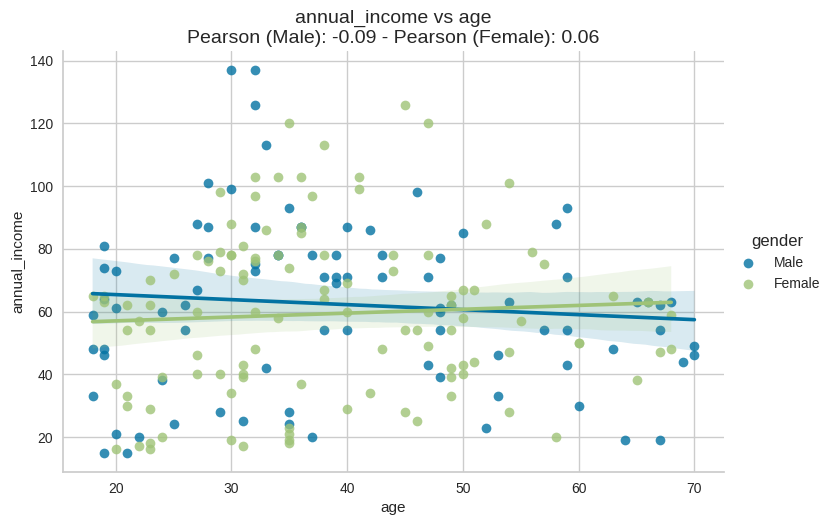

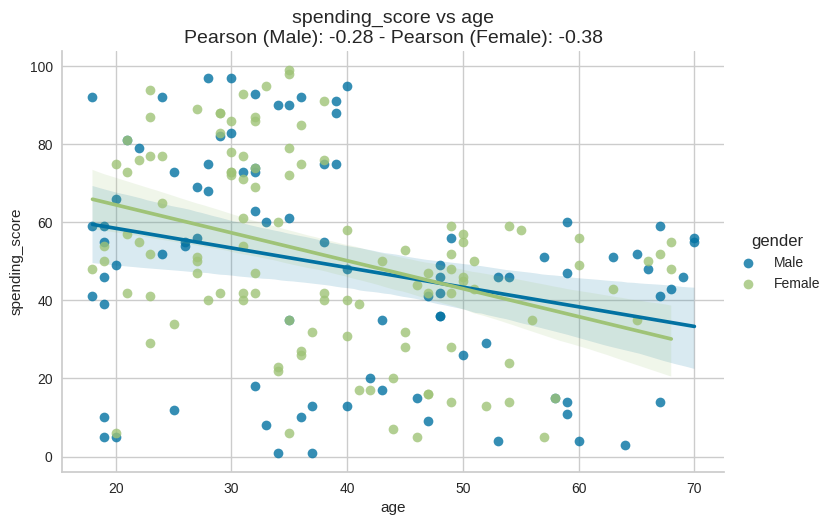

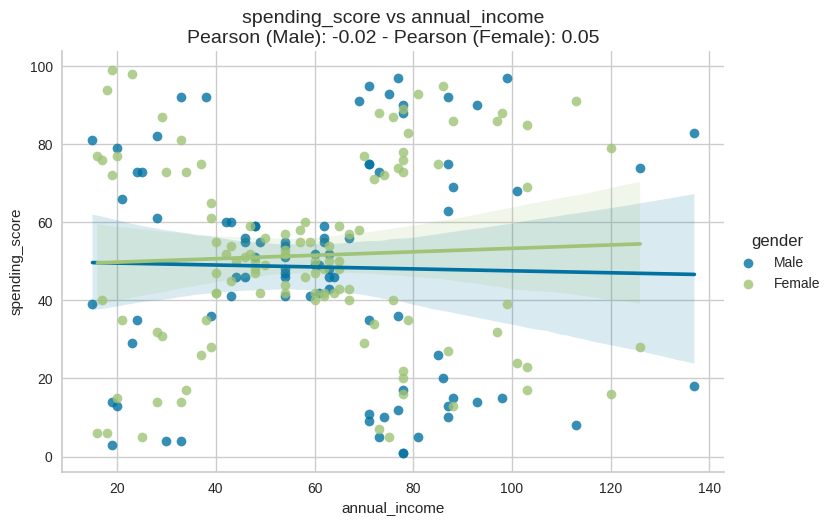

In [16]:
# Function to generate pairwise plots with Pearson correlation
def plot_lm_with_corr(data, cols, hue_col):
    # Generate all combinations of two columns
    combs = list(itertools.combinations(cols, 2))  # Avoids repetition like (a,b) and (b,a)

    for x, y in combs:
        # Calculate Pearson correlations for hue groups (assuming 2 groups, e.g., males and females)
        for hue_val in data[hue_col].unique():
            subset = data[data[hue_col] == hue_val]
            corr, _ = pearsonr(subset[x].values, subset[y].values)

        # Create the lmplot
        sns.lmplot(x=x, y=y, data=data, hue=hue_col, aspect=1.5)

        # Calculate Pearson correlations to add to the plot for the two groups
        corr_vals = {hue_val: pearsonr(data[data[hue_col] == hue_val][x], data[data[hue_col] == hue_val][y])[0]
                     for hue_val in data[hue_col].unique()}

        # Create a title with Pearson correlation values
        title = f"{y} vs {x}\n" + \
                " - ".join([f'Pearson ({hue_val}): {corr:.2f}' for hue_val, corr in corr_vals.items()])
        plt.title(title, fontsize=14)

# Example usage with your columns and hue for gender
plot_lm_with_corr(df, num_cols, 'gender')


#### **c.3. Multivariate**

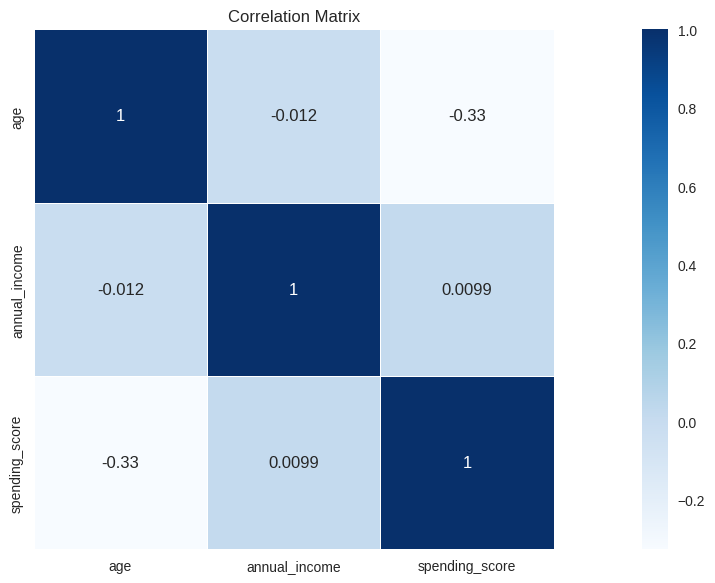

In [17]:
plt.figure(figsize=(18,6))
corr_mx = df[num_cols].corr()
sns.heatmap(corr_mx,
            linewidths=0.5,
            square=True,
            cmap="Blues",
            annot=True)
plt.title("Correlation Matrix")
plt.tight_layout()

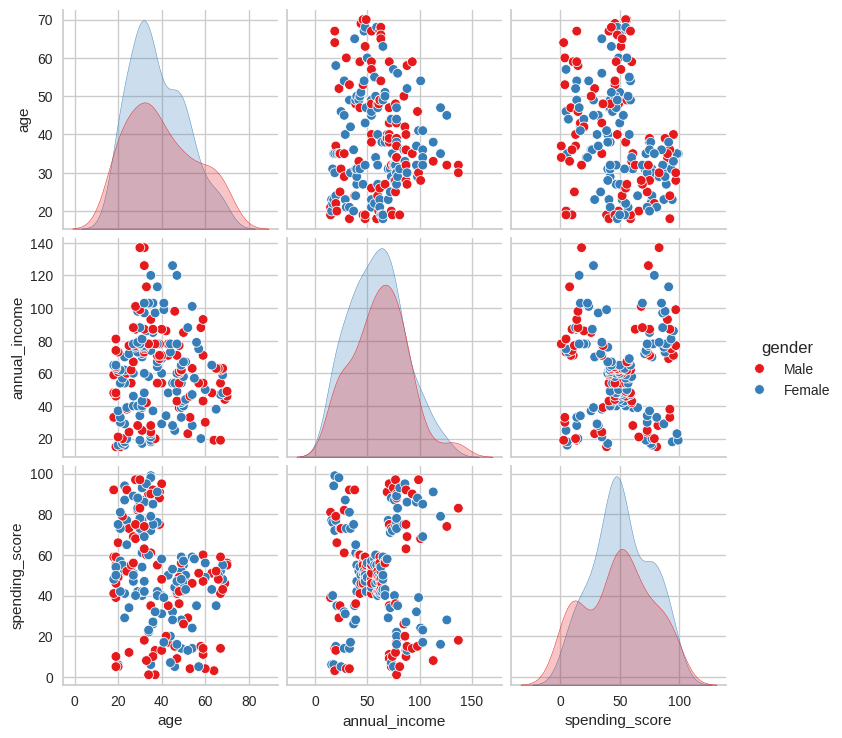

In [18]:
sns.pairplot(df, vars=num_cols, hue='gender', palette='Set1')
plt.show()

# **II. Feature Engineering**

In [19]:
df.drop(['customer_id', 'gender'],axis=1,inplace=True)

In [20]:
def preprocess_and_scale(df):
    df_processed = df.copy()

    for col in df_processed.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_processed)

    return df_scaled, scaler

df_scaled, scaler = preprocess_and_scale(df)

# **III. Clustering**

## Helper Functions for Identifying the Number of Clusters

⚠️ **plot_elbow_curve**, **plot_silhouette_scores**, **plot_silhouette_subplots** and **evaluate_clusters** are only for cluster based algorithms like Kmeans and AgglomerativeClustering. On the other hand **plot_clusters** will be used for all algorithms.


---

**Introduction to Clustering Evaluation Metrics**

In the realm of clustering analysis, it's essential to assess the performance and effectiveness of clustering algorithms. This evaluation is accomplished through various metrics that quantify the quality of the clusters formed. Each metric offers unique insights into how well the clustering algorithm has performed, allowing practitioners to compare different clustering approaches or optimize hyperparameters.

The scores commonly used to evaluate clustering results include the Silhouette Score, Davies-Bouldin Score, and Calinski-Harabasz Score. These metrics provide a standardized way to measure the compactness and separation of clusters, helping to determine the optimal number of clusters for a given dataset. Understanding the ranges and implications of these scores is vital for making informed decisions in clustering analysis. Below, we delve into each score's definition and typical value ranges to facilitate a comprehensive understanding of their application in assessing clustering quality.
1. KElbow Method:
  - **Definition**: A technique used to find the optimal number of clusters (K) in KMeans by plotting the explained variance (inertia or distortion) for different values of K.
  - **Range**: The plot typically shows the "elbow" point, where the explained variance starts to diminish rapidly.
  - **Interpretation**: The elbow point (where the curve bends sharply) indicates the optimal number of clusters. This is where adding more clusters doesn’t significantly improve the model's performance.

2. Davies-Bouldin Score (DB Score):

  - **Definition**: Measures the average similarity ratio of each cluster with its most similar cluster, using the ratio of within-cluster distances to between-cluster distances.
  - **Range**: The Davies-Bouldin score ranges from 0 to ∞.
  - **Interpretation**: A lower score indicates better clustering because it reflects less overlap between clusters and tighter within-cluster distances.

3. Calinski-Harabasz Score (CH Score):
  - **Definition**: Also known as the Variance Ratio Criterion, it measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion.
  - **Range**: There is no specific upper limit, but higher values are better.
  - **Interpretation**: A higher score indicates better-defined clusters, meaning the clusters are more separated and compact.

4. Silhouette Score:
  - **Definition**: Evaluates how similar a data point is to its own cluster compared to other clusters. It’s based on the mean intra-cluster distance and the mean nearest-cluster distance.
  - **Range**: The Silhouette score ranges from -1 to 1.
  - **Interpretation**:
    * 1: Perfect clustering, where points are well-matched to their own cluster and poorly matched to others.
    * 0: Data points are on the boundary of two clusters.
    Negative values: Indicate that points may be assigned to the wrong cluster.

In [21]:
def plot_elbow_curve(df, model, max_clusters=10):
    # Models that require 'k' (number of clusters)
    cluster_based_models = [KMeans, AgglomerativeClustering]

    if any(isinstance(model, cls) for cls in cluster_based_models):
        fig, ax = plt.subplots(figsize=(10, 6))

        visualizer = KElbowVisualizer(model, k=(2, max_clusters), ax=ax)
        visualizer.fit(df)
        visualizer.finalize()

        ax.set_title('Elbow Method for Optimal K', fontsize=14)
        ax.set_xlabel('Number of Clusters (K)')
        ax.set_ylabel('Distortion Score')
        plt.show()
    # For models that don't use 'k' (e.g., DBSCAN, OPTICS, AffinityPropagation)
    else:
        print(f"{model.__class__.__name__} does not use a pre-defined number of clusters. Consider checking Silhouette Score instead for clustering evaluation.")

In [22]:
def plot_silhouette_scores(df, model, max_clusters=10):
    silhouettes = []

    for k in range(2, max_clusters + 1):
        model.set_params(n_clusters=k)  # Set the number of clusters dynamically
        model.fit(df)
        labels = model.labels_
        silhouette_avg = silhouette_score(df, labels)
        silhouettes.append(silhouette_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouettes, marker='o', linestyle='--', color='r')

    for i, score in enumerate(silhouettes):
        plt.annotate(f'{score:.4f}', (i + 2, score), fontsize=15, ha='right', va='center')

    plt.title('Silhouette Score for Different Number of Clusters', fontsize=14)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.xticks(range(2, max_clusters + 1))  # Ensure x-ticks are set correctly
    plt.show()

In [23]:
def plot_silhouette_subplots(df, model_class, cluster_range=range(2, 11), figsize=(15, 10)):
    n_clusters = len(cluster_range)
    n_cols = 3
    n_rows = (n_clusters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    fig.tight_layout(pad=3.0)
    axes = axes.flatten()

    for idx, n in enumerate(cluster_range):
        model = model_class.set_params(n_clusters=n)
        labels = model.fit_predict(df)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[idx])
        visualizer.fit(df)
        silhouette_score = visualizer.silhouette_score_

        axes[idx].set_title(f'Clusters = {n}\nSilhouette Score = {silhouette_score:.4f}', fontsize=14)

    # Remove unused subplots if any
    for idx in range(len(cluster_range), len(axes)):
        fig.delaxes(axes[idx])

    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(f'Silhouette Visualizers for {model.__class__.__name__}', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [24]:
def evaluate_clusters(X, model_class, cluster_range=range(2, 11)):
    results = []

    for k in cluster_range:
        model = model_class.set_params(n_clusters=k)

        labels = model.fit_predict(X)

        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        sil_score = silhouette_score(X, labels)

        results.append({
            'Clusters': k,
            'Davies-Bouldin Score': db_score,
            'Calinski-Harabasz Score': ch_score,
            'Silhouette Score': sil_score
        })

    results_df = pd.DataFrame(results)
    return results_df

In [25]:
def plot_clusters(ax, data, x, y, title, cluster_col, model=None, centroids=None):
    if model is not None:
        palette = sns.color_palette('hls', np.unique(data[cluster_col]).shape[0])
    else:
        palette = sns.color_palette('hls')

    sns.scatterplot(ax=ax, data=data, x=x, y=y, hue=cluster_col, palette=palette)

    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    legend = ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('lightgray')

## **1. Kmeans Clustering Without PCA**

K-Means Clustering is an unsupervised machine learning algorithm used to partition data into K distinct clusters. Here’s a simple explanation:

1. Initialization: Select K initial centroids randomly from the dataset.
2. Assignment: Assign each data point to the nearest centroid, creating K clusters.
3. Update: Calculate the new centroids by averaging the data points in each cluster.
4. Repeat: Repeat the assignment and update steps until the centroids no longer change significantly or a set number of iterations is reached.


The goal is to minimize the variance within each cluster while maximizing the variance between clusters, effectively grouping similar data points together.

---
- **When to use:** When you have a large dataset with spherical clusters and need fast computation; effective for numerical data but sensitive to outliers.
- **When not to use:** Avoid when data contains many outliers or is non-spherical, as the algorithm may misclassify points.

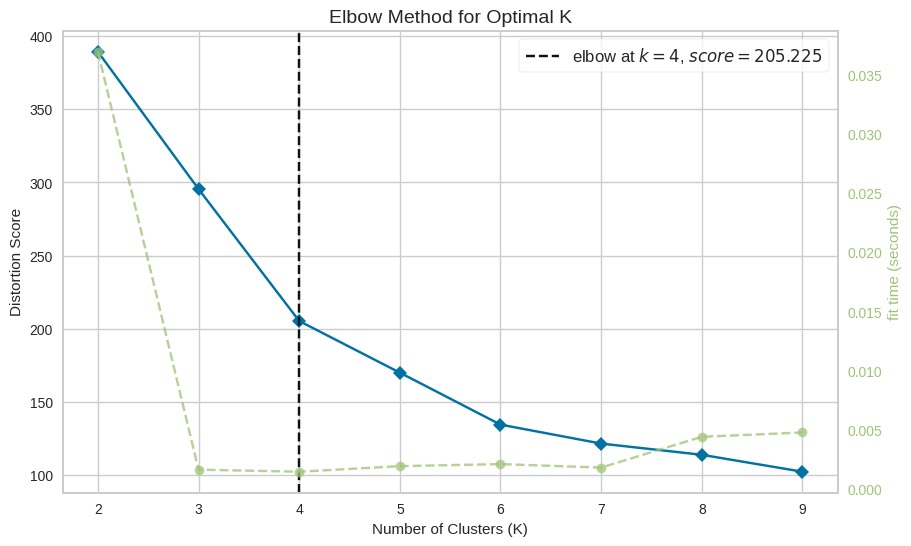

In [26]:
plot_elbow_curve(df_scaled, KMeans(init='k-means++', n_init='auto', random_state=42))

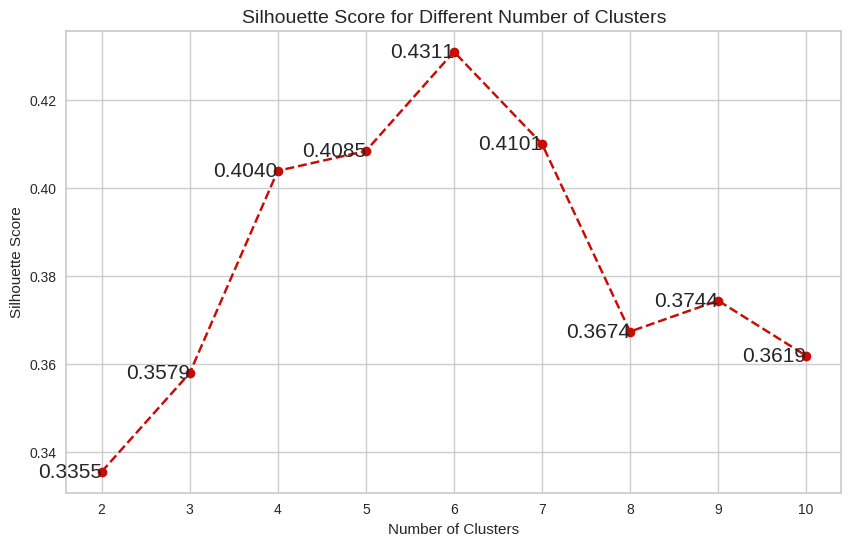

In [27]:
plot_silhouette_scores(df_scaled, KMeans(init='k-means++', n_init='auto', random_state=42))

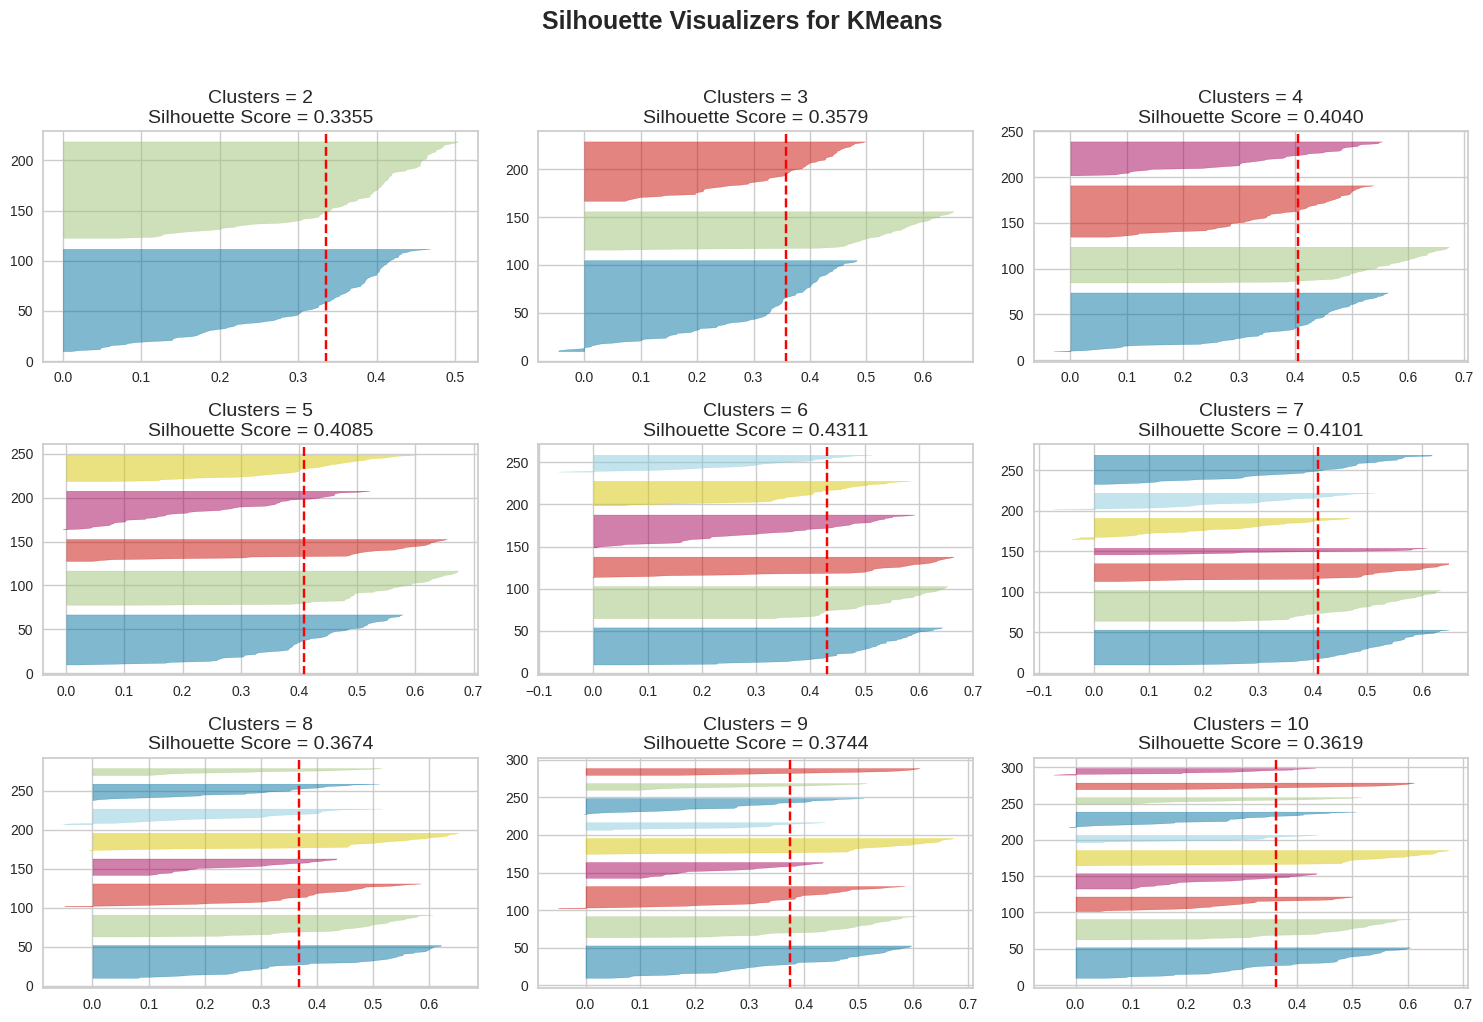

In [28]:
plot_silhouette_subplots(df_scaled, KMeans(init='k-means++', n_init='auto', random_state=42))

In [29]:
evaluate_clusters(df_scaled, KMeans(init='k-means++', n_init='auto', random_state=42))

Clusters  Davies-Bouldin Score  Calinski-Harabasz Score  Silhouette Score
0         2              1.260682               107.095567          0.335472
1         3              1.032689               101.529619          0.357923
2         4              0.930796               125.676397          0.403958
3         5              0.888969               123.418710          0.408469
4         6              0.834966               134.475171          0.431065
5         7              0.880755               126.825864          0.410091
6         8              0.952068               117.278574          0.367366
7         9              0.918146               116.378843          0.374421
8        10              0.988547               115.751443          0.361870

In [30]:
def create_kmeans_clusters(df, df_scaled, n_clusters, scaler):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)

    df_cl = df.copy()
    df_cl['cluster'] = cluster_labels
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    return df_cl, centroids, kmeans

df_kmeans_4_cl, centroids_inverse_4, kmeans_4 = create_kmeans_clusters(df, df_scaled, 4, scaler)
df_kmeans_6_cl, centroids_inverse_6, kmeans_6 = create_kmeans_clusters(df, df_scaled, 6, scaler)

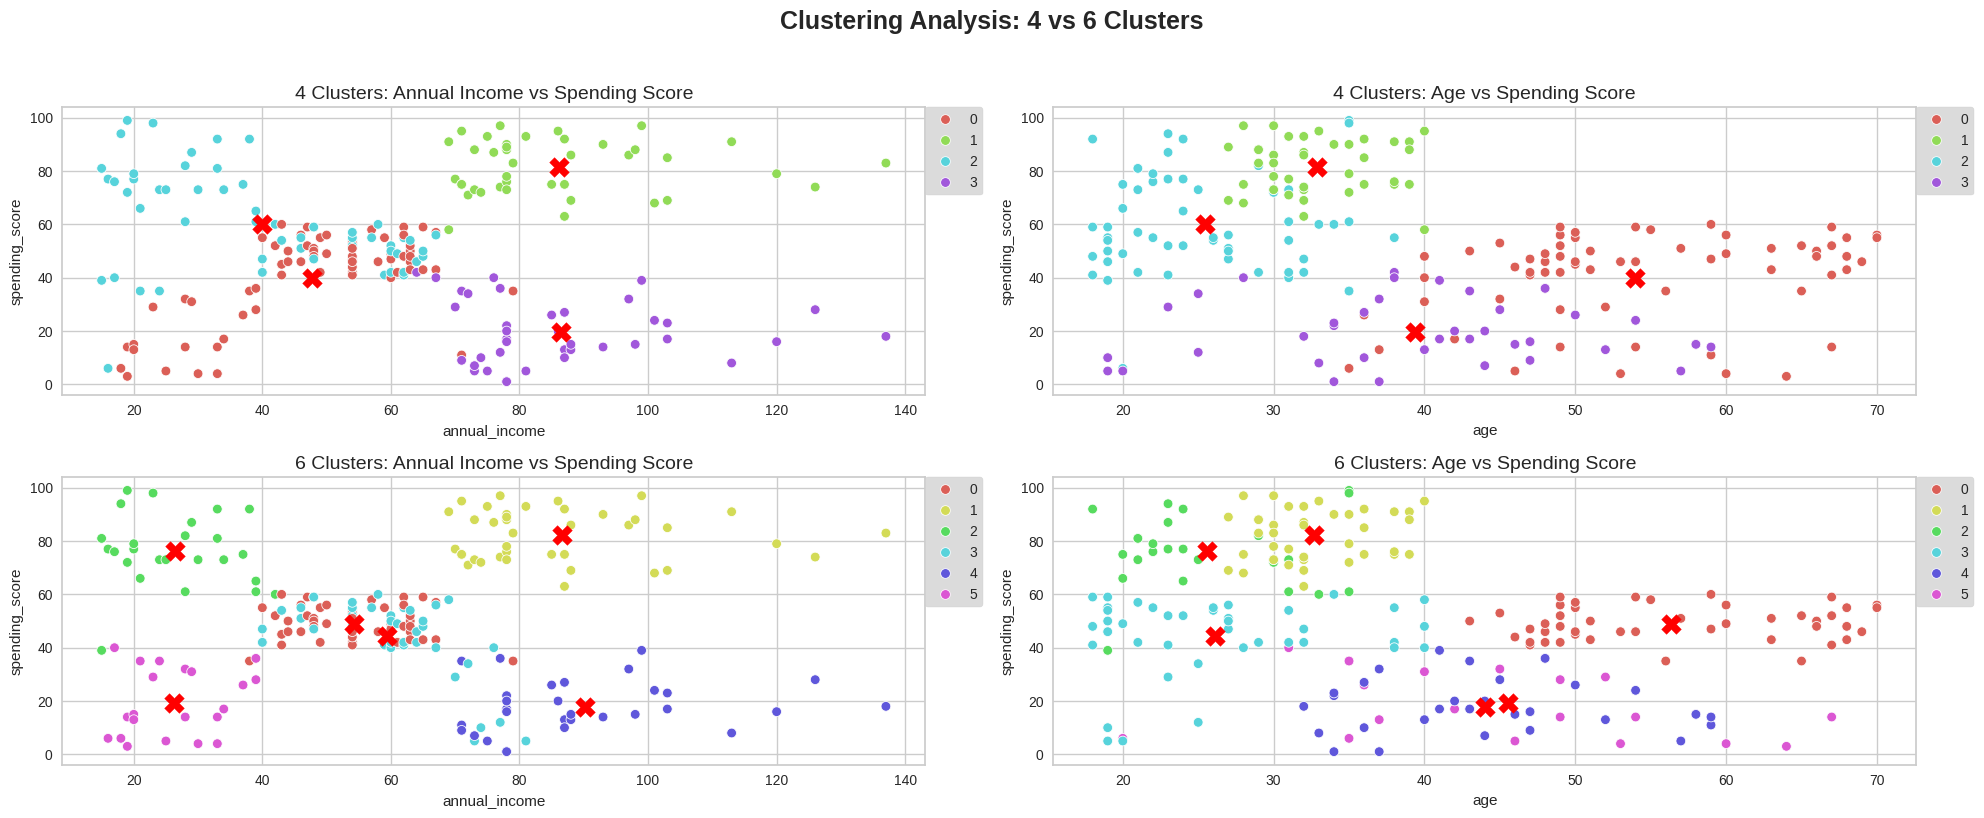

In [31]:
datasets = [
    (df_kmeans_4_cl, centroids_inverse_4, kmeans_4, '4 Clusters'),
    (df_kmeans_6_cl, centroids_inverse_6, kmeans_6, '6 Clusters')
]

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

for i, (df_cl, centroids, kmeans, title) in enumerate(datasets):
    plot_clusters(axes[i, 0], df_cl, 'annual_income', 'spending_score',
                  f'{title}: Annual Income vs Spending Score', 'cluster', kmeans, centroids[:, [1, 2]])
    plot_clusters(axes[i, 1], df_cl, 'age', 'spending_score',
                  f'{title}: Age vs Spending Score', 'cluster', kmeans, centroids[:, [0, 2]])

plt.suptitle('Clustering Analysis: 4 vs 6 Clusters', fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [32]:
df_kmeans_4_cl.select_dtypes('number').groupby('cluster').agg(["count", "mean", "median"])

age                   annual_income                   spending_score                  
        count       mean median         count       mean median          count       mean median
cluster                                                                                         
0          65  53.984615   52.0            65  47.707692   49.0             65  39.969231   46.0
1          40  32.875000   32.0            40  86.100000   78.5             40  81.525000   83.0
2          57  25.438596   24.0            57  40.000000   40.0             57  60.298246   56.0
3          38  39.368421   40.5            38  86.500000   79.5             38  19.578947   17.0

In [33]:
df_kmeans_6_cl.select_dtypes('number').groupby('cluster').agg(["count", "mean", "median"])

age                   annual_income                   spending_score                  
        count       mean median         count       mean median          count       mean median
cluster                                                                                         
0          45  56.333333   54.0            45  54.266667   54.0             45  49.066667   49.0
1          39  32.692308   32.0            39  86.538462   79.0             39  82.128205   83.0
2          25  25.560000   24.0            25  26.480000   25.0             25  76.240000   76.0
3          40  26.125000   25.0            40  59.425000   60.0             40  44.450000   48.0
4          30  44.000000   43.5            30  90.133333   87.0             30  17.933333   16.5
5          21  45.523810   46.0            21  26.285714   25.0             21  19.380952   15.0

## **2. Kmeans Clustering With PCA**

Principal Component Analysis (PCA) is a dimensionality reduction technique used to simplify data while retaining its essential features. Here’s a brief overview:

1. **Standardization**: Scale the data so that each feature has a mean of 0 and a variance of 1. This ensures that PCA is not biased towards features with larger scales.
2. **Covariance Matrix**: Compute the covariance matrix to understand how different features relate to one another.
3. **Eigenvalues and Eigenvectors**: Calculate the eigenvalues and eigenvectors of the covariance matrix. The eigenvectors represent the directions of maximum variance, while the eigenvalues indicate the magnitude of variance in those directions.
4. **Select Components**: Choose the top K eigenvectors (principal components) based on their eigenvalues. These components capture the most variance in the data.
5. **Transform Data**: Project the original data onto the selected principal components, reducing its dimensionality while preserving significant patterns.

PCA helps in visualizing high-dimensional data and improving the performance of machine learning models by reducing noise and redundancy.

---
- **When to use:** Useful for dimensionality reduction before applying clustering methods, especially with high-dimensional data.
- **When not to use:** Don't use if you aim for interpretability, as it transforms the data into principal components that may obscure original features.

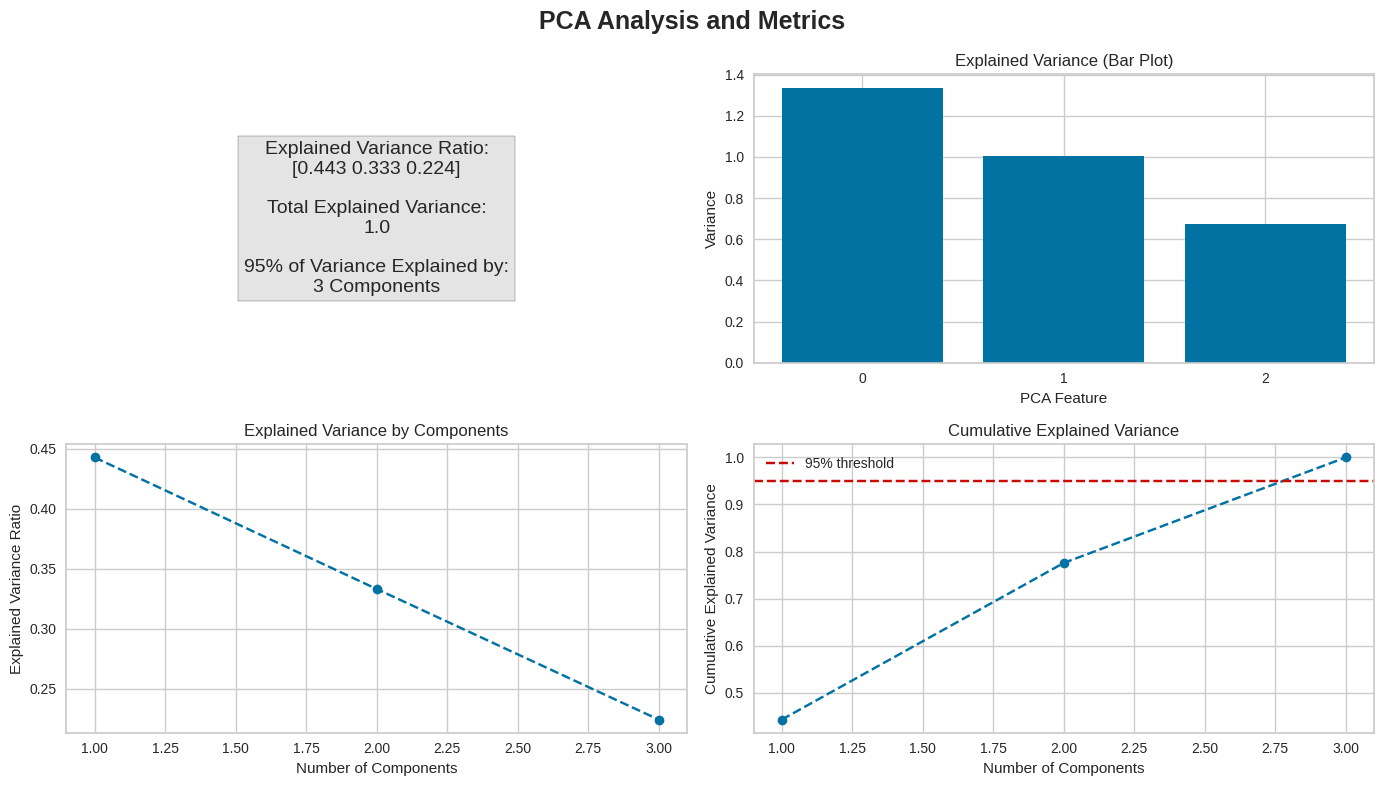

In [34]:
def plot_pca_analysis(df, threshold=0.95):
    pca = PCA()
    pca.fit(df)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    features = range(pca.n_components_)

    components_for_threshold = np.argmax(cumulative_variance >= threshold) + 1
    best_dimension = np.argmax(cumulative_variance >= threshold)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    axes[0, 0].axis('off')
    score_text = (f'Explained Variance Ratio:\n{np.round(explained_variance, 3)}\n\n'
                  f'Total Explained Variance:\n{round(sum(explained_variance), 3)}\n\n'
                  f'{int(threshold * 100)}% of Variance Explained by:\n'
                  f'{components_for_threshold} Components')
    axes[0, 0].text(0.5, 0.5, score_text, fontsize=14, ha='center', va='center',
                    bbox=dict(facecolor='lightgray', alpha=0.6))

    axes[0, 1].bar(features, pca.explained_variance_)
    axes[0, 1].set_xlabel('PCA Feature')
    axes[0, 1].set_ylabel('Variance')
    axes[0, 1].set_title('Explained Variance (Bar Plot)')
    axes[0, 1].set_xticks(features)

    axes[1, 0].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Explained Variance Ratio')
    axes[1, 0].set_title('Explained Variance by Components')
    axes[1, 0].grid(True)

    axes[1, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    axes[1, 1].axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold * 100)}% threshold')
    axes[1, 1].set_xlabel('Number of Components')
    axes[1, 1].set_ylabel('Cumulative Explained Variance')
    axes[1, 1].set_title('Cumulative Explained Variance')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.suptitle('PCA Analysis and Metrics', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_pca_analysis(df_scaled, threshold=0.95)

In [35]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
pca_features = pca.transform(df_scaled)

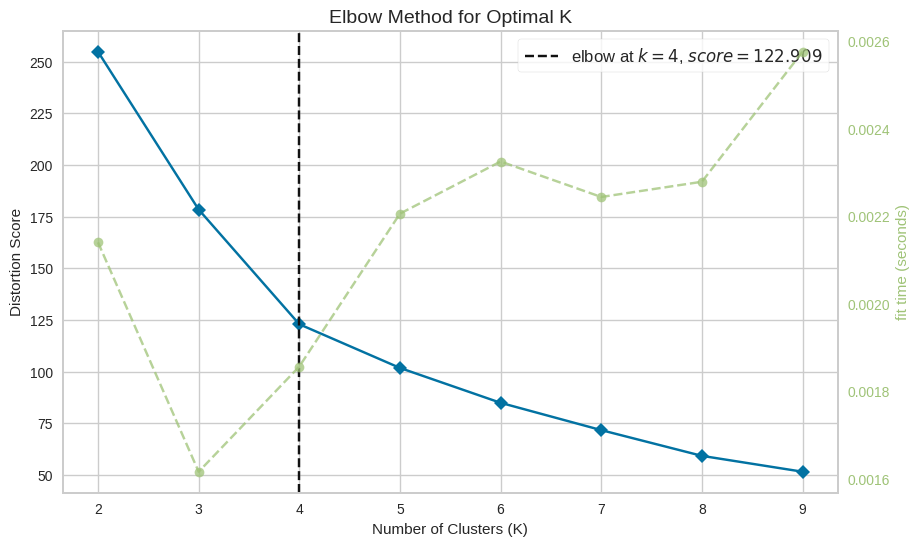

In [36]:
plot_elbow_curve(pca_features, KMeans(init='k-means++', n_init='auto', random_state=42))

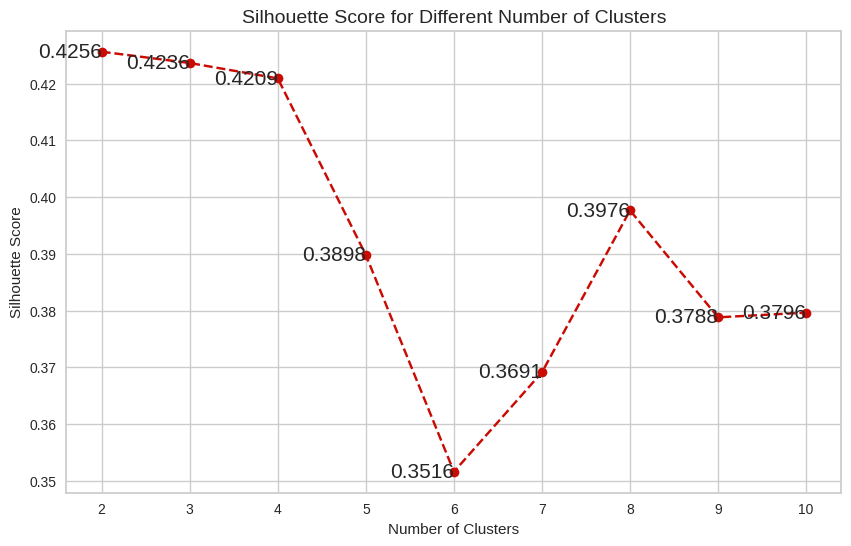

In [37]:
plot_silhouette_scores(pca_features, KMeans(init='k-means++', n_init='auto', random_state=42))

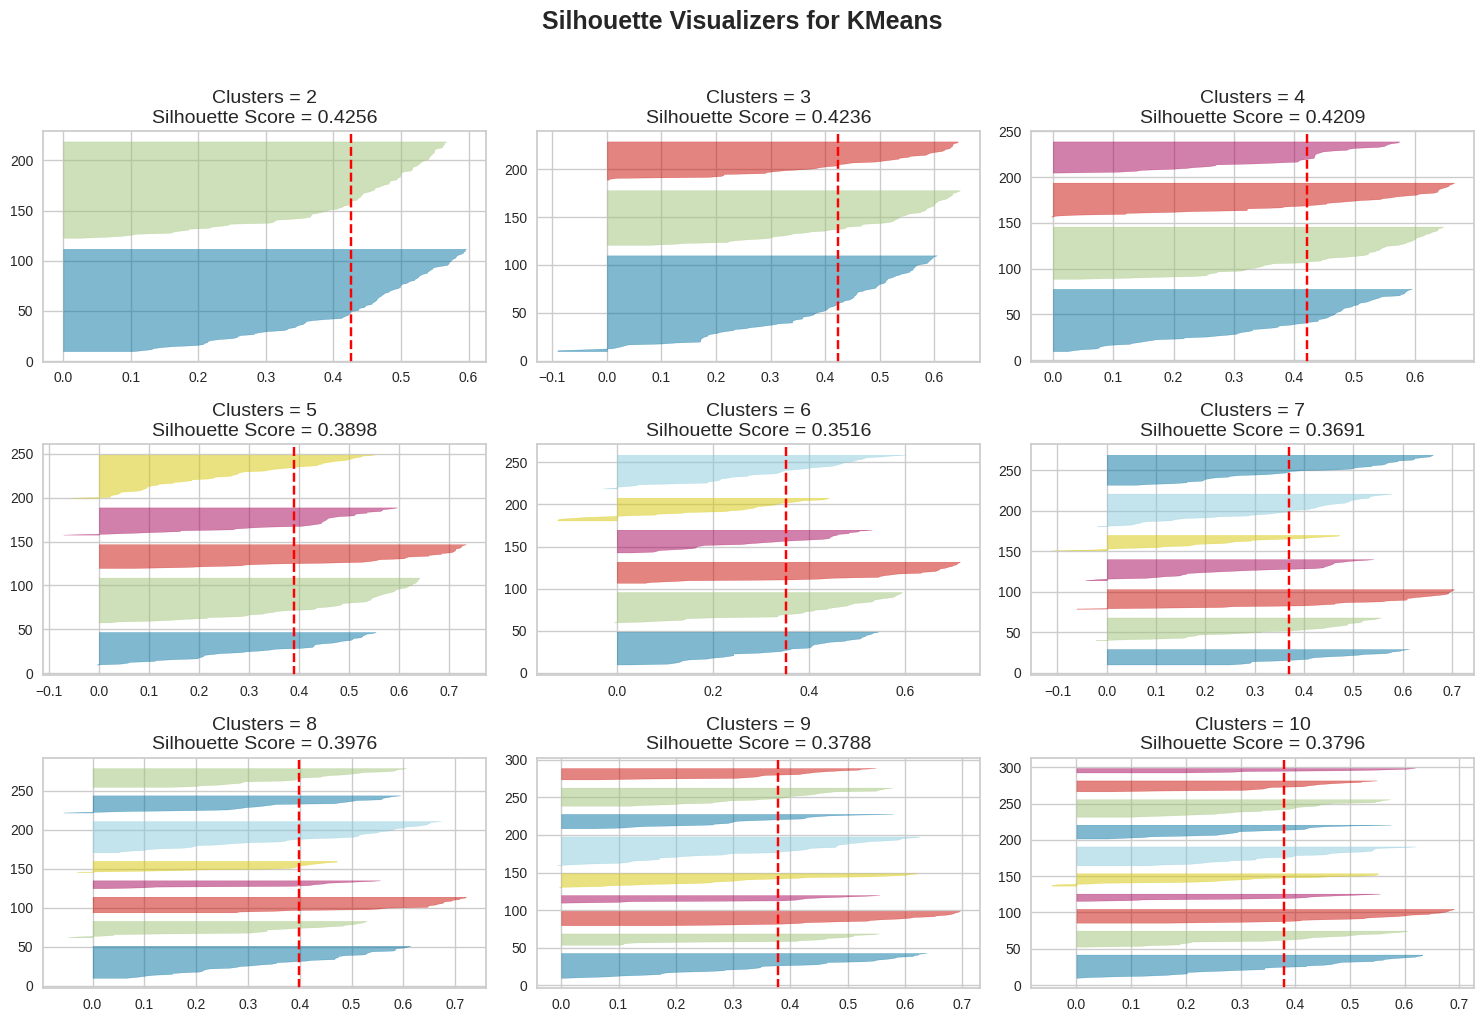

In [38]:
plot_silhouette_subplots(pca_features, KMeans(init='k-means++', n_init='auto', random_state=42))

In [39]:
evaluate_clusters(pca_features, KMeans(init='k-means++', n_init='auto', random_state=42))

Clusters  Davies-Bouldin Score  Calinski-Harabasz Score  Silhouette Score
0         2              0.957548               163.628137          0.425633
1         3              0.765174               158.434628          0.423642
2         4              0.824742               182.079755          0.420929
3         5              0.838537               174.265101          0.389786
4         6              0.935174               174.009332          0.351571
5         7              0.812793               176.828762          0.369102
6         8              0.805046               188.292389          0.397646
7         9              0.822981               191.904431          0.378796
8        10              0.821404               196.123326          0.379627

In [40]:
df_kmeans_2_pca, centroids_inverse_4, kmeans_2_pca = create_kmeans_clusters(df, df_scaled, 2, scaler)
df_kmeans_4_pca, centroids_inverse_6, kmeans_4_pca = create_kmeans_clusters(df, df_scaled, 4, scaler)

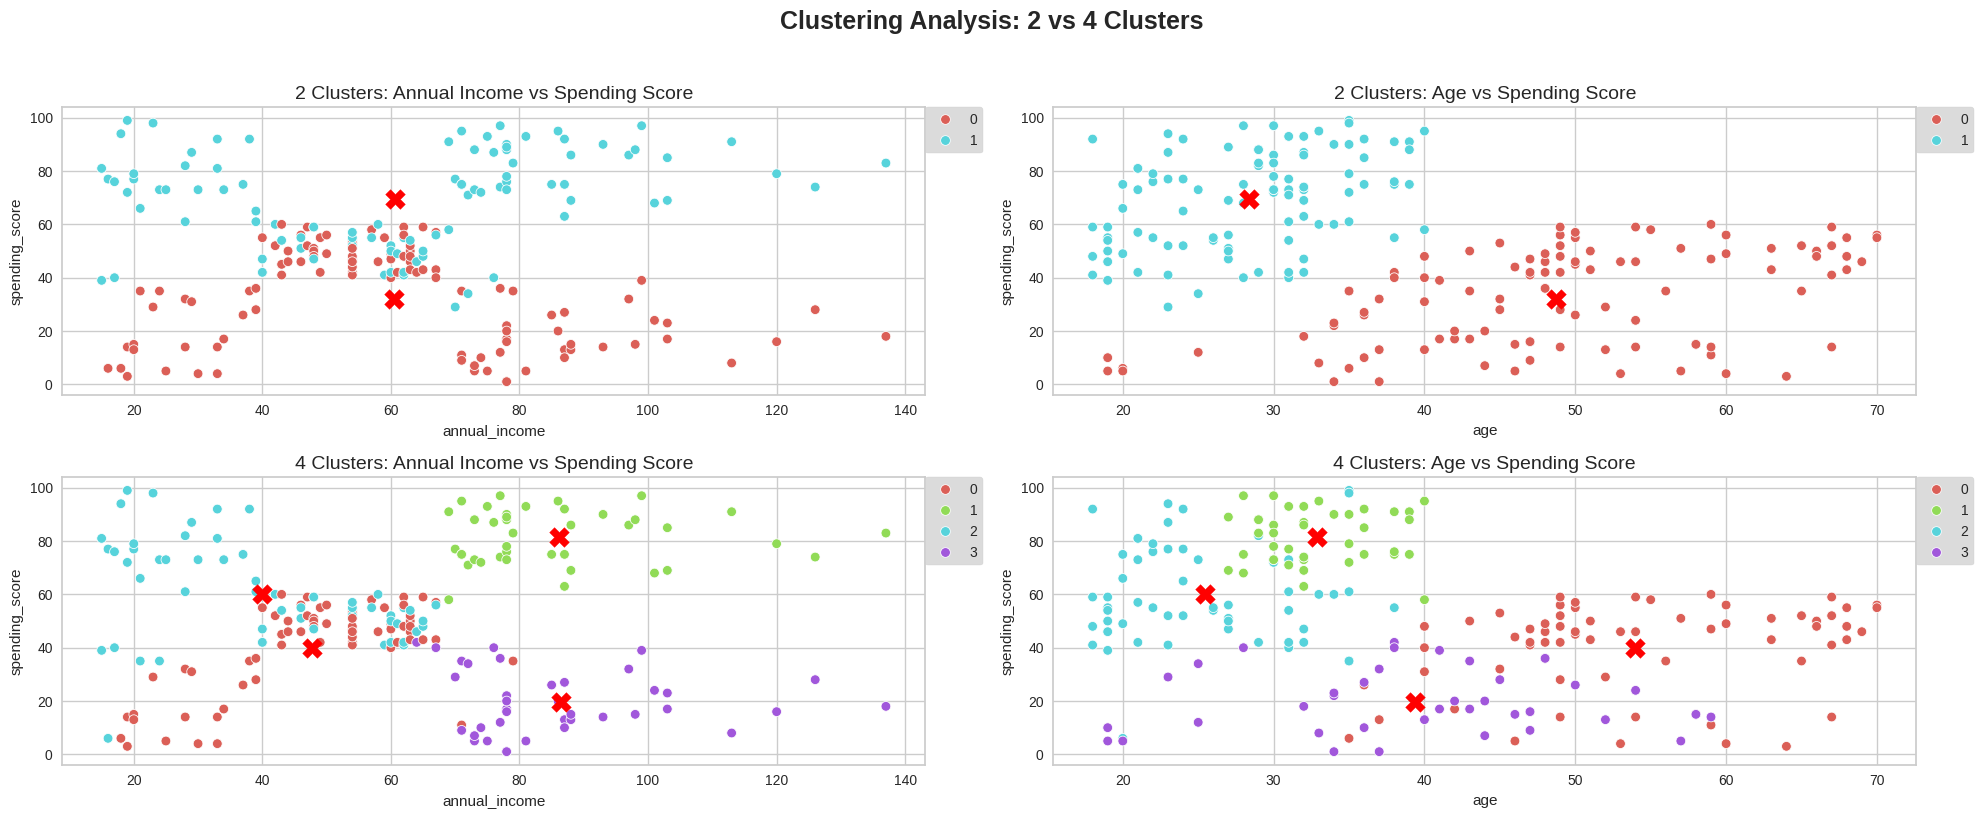

In [41]:
datasets = [
    (df_kmeans_2_pca, centroids_inverse_4, kmeans_2_pca, '2 Clusters'),
    (df_kmeans_4_pca, centroids_inverse_6, kmeans_4_pca, '4 Clusters')
]

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

for i, (df_cl, centroids, kmeans, title) in enumerate(datasets):
    plot_clusters(axes[i, 0], df_cl, 'annual_income', 'spending_score',
                  f'{title}: Annual Income vs Spending Score', 'cluster', kmeans, centroids[:, [1, 2]])
    plot_clusters(axes[i, 1], df_cl, 'age', 'spending_score',
                  f'{title}: Age vs Spending Score', 'cluster', kmeans, centroids[:, [0, 2]])

plt.suptitle('Clustering Analysis: 2 vs 4 Clusters', fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()


## **3. Hierchical Clustering**


Hierarchical Clustering is an unsupervised learning algorithm that groups data points into a hierarchy of clusters. Here's a simple breakdown:

1. **Agglomerative Approach**: This is the most common method, which starts with each data point as its own cluster and then merges them iteratively. Alternatively, divisive clustering starts with one cluster and splits it into smaller ones.

2. **Distance Metric**: Define a distance metric (e.g., Euclidean, Manhattan) to measure the similarity between clusters.

3. **Linkage Criteria**: Choose a linkage method to determine how to measure the distance between clusters. Common options include:

  - **Single Linkage**: Distance between the closest points of two clusters.
  - **Complete Linkage**: Distance between the farthest points of two clusters.
  - **Average Linkage**: Average distance between all points in two clusters.
  - **Ward Linkage**: This method minimizes the total within-cluster variance by merging clusters that result in the smallest increase in the overall variance, making it effective for creating compact and well-separated clusters.

4. **Merge Clusters**: Iteratively merge the two closest clusters based on the chosen distance metric and linkage method until a stopping criterion is met (e.g., a desired number of clusters or a threshold distance).

5. **Dendrogram**: Visualize the clustering process using a dendrogram, which shows the arrangement of clusters and the distances at which merges occur.

Hierarchical clustering is useful for understanding data structure and relationships, but it can be computationally intensive for large datasets.

---
- **When to use:** Ideal when you want to understand the data hierarchy or when the number of clusters is unknown; can provide insight into data structure.
- **When not to use:** Not ideal for very large datasets due to high computational costs and potential memory issues.

In [42]:
df_hier_clus = df.copy()

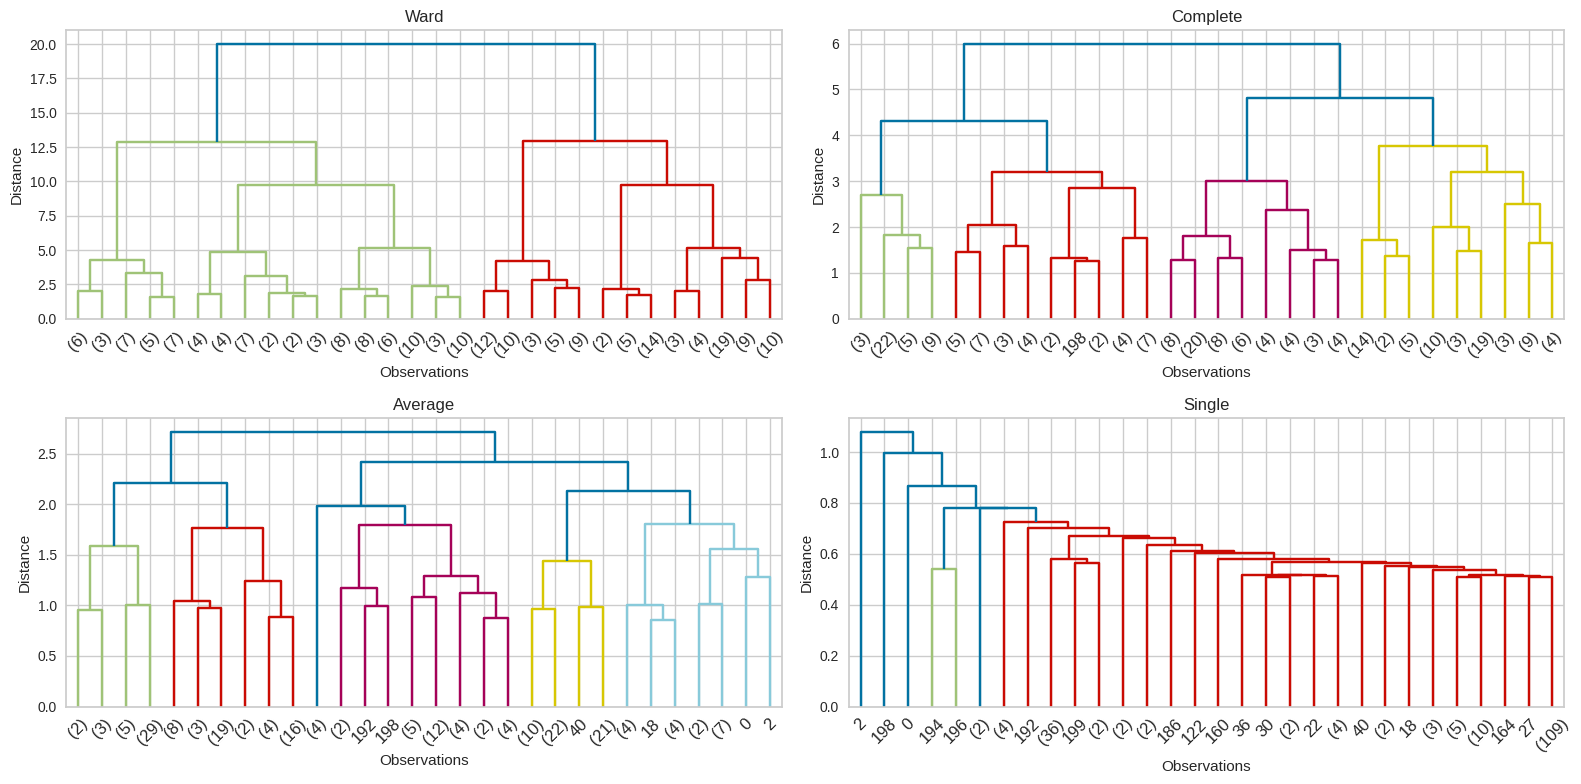

In [43]:
methods = {
    "Ward": "ward",
    "Complete": "complete",
    "Average": "average",
    "Single": "single"
}

plt.figure(figsize=(16, 8))

for i, (title, method) in enumerate(methods.items(), start=1):
    plt.subplot(2, 2, i)
    plt.title(title)
    plt.xlabel("Observations")
    plt.ylabel("Distance")

    hc_method = linkage(df_scaled, method=method)
    dendrogram(hc_method, leaf_font_size=12, truncate_mode='lastp')

plt.tight_layout()
plt.show()

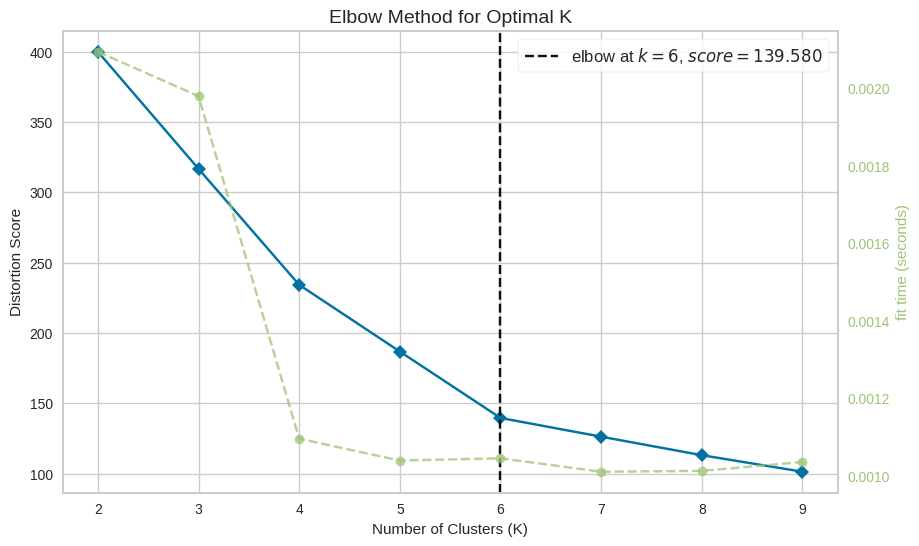

In [44]:
plot_elbow_curve(df_scaled, AgglomerativeClustering())

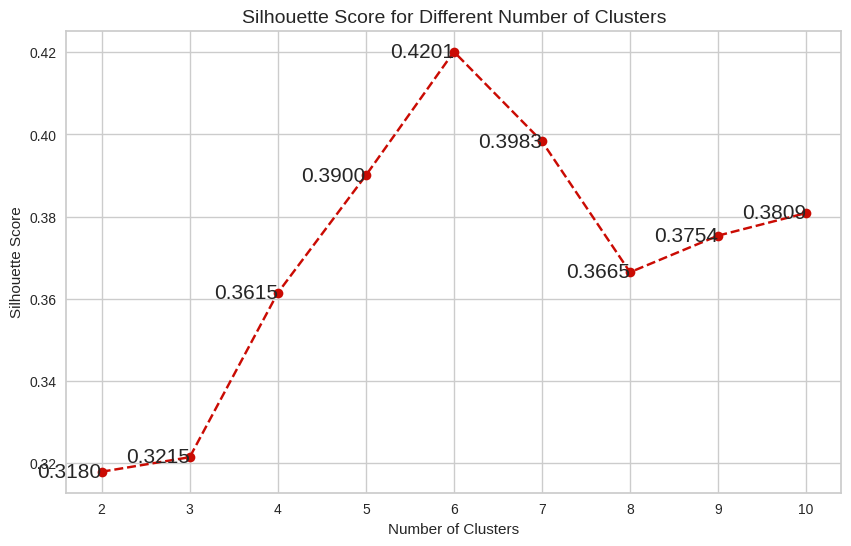

In [45]:
plot_silhouette_scores(df_scaled, AgglomerativeClustering())

In [46]:
def evaluate_agglomerative_clustering(X, range_n_clusters):
    results = []

    for num_clusters in range_n_clusters:
        agg_model = AgglomerativeClustering(n_clusters=num_clusters)
        agg_model.fit(X)

        cluster_labels = agg_model.labels_
        n_clusters = len(np.unique(cluster_labels))

        result = {
            'Number of Clusters': num_clusters
        }

        # Check if there are valid clusters
        if n_clusters > 1:
            result['Silhouette Score'] = silhouette_score(X, cluster_labels)
            result['Davies-Bouldin Score'] = davies_bouldin_score(X, cluster_labels)
            result['Calinski-Harabasz Score'] = calinski_harabasz_score(X, cluster_labels)
        else:
            result['Silhouette Score'] = np.nan
            result['Davies-Bouldin Score'] = np.nan
            result['Calinski-Harabasz Score'] = np.nan

        results.append(result)

    agg_df = pd.DataFrame(results)
    return agg_df

range_n_clusters = range(2, 11)
agg_results = evaluate_agglomerative_clustering(df_scaled, range_n_clusters)
agg_results.sort_values(by='Silhouette Score', ascending=False)

Number of Clusters  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
4                   6          0.420117              0.852102               127.986454
5                   7          0.398295              0.851329               120.686805
3                   5          0.390028              0.916289               107.826560
8                  10          0.380889              0.885471               117.221895
7                   9          0.375385              0.858235               117.475123
6                   8          0.366479              0.841587               118.066796
2                   4          0.361451              1.016382               102.019399
1                   3          0.321489              1.127729                88.101741
0                   2          0.317957              1.308296                99.000668

In [47]:
Agg1 = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
y_agg= Agg1.fit_predict(df_scaled)
df_hier_clus['cluster'] = y_agg

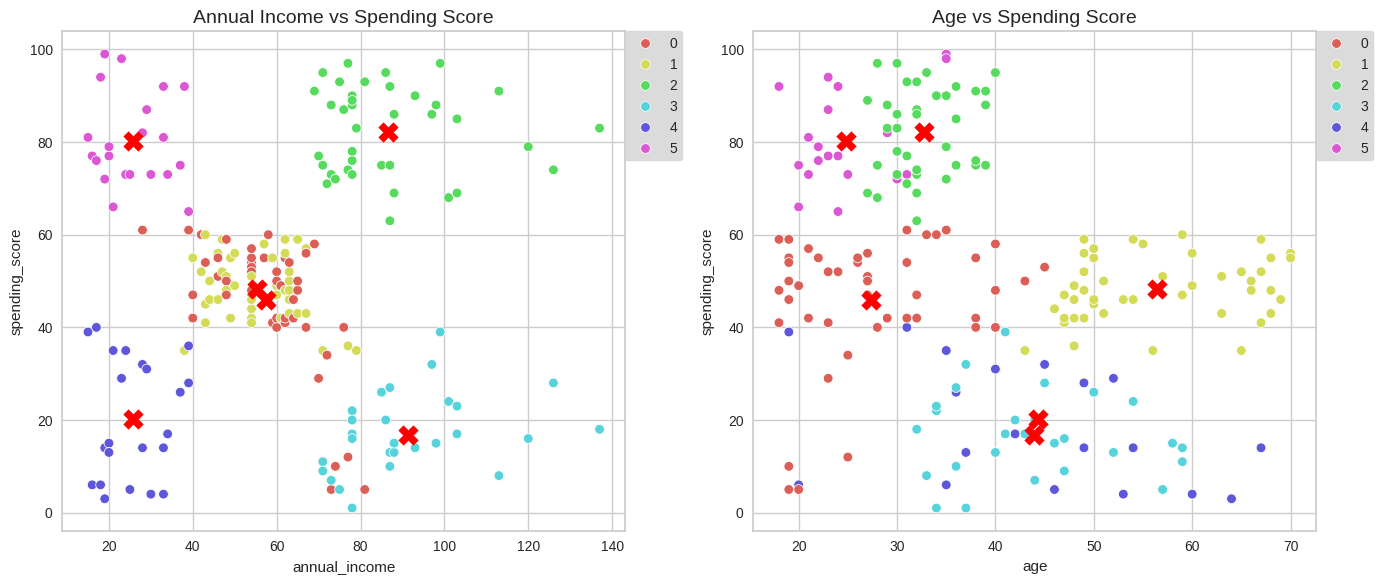

In [48]:
def plot_hierarchical_clusters(df, cluster_col, k):
    # Calculate centroids (mean values for each cluster)
    centroids = df_hier_clus.groupby(cluster_col).mean()[['annual_income', 'spending_score', 'age']].values

    # Create subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First plot: Annual Income vs Spending Score
    plot_clusters(axes[0], df, 'annual_income', 'spending_score',
                  'Annual Income vs Spending Score', cluster_col, None, centroids[:, [0, 1]])

    # Second plot: Age vs Spending Score
    plot_clusters(axes[1], df, 'age', 'spending_score',
                  'Age vs Spending Score', cluster_col, None, centroids[:, [2, 1]])

    # Adjust the layout
    plt.tight_layout()
    plt.show()


plot_hierarchical_clusters(df_hier_clus, cluster_col='cluster', k=6)

In [49]:
df_hier_clus.select_dtypes('number').groupby('cluster').agg(["count", "mean", "median"])

age                   annual_income                   spending_score                  
        count       mean median         count       mean median          count       mean median
cluster                                                                                         
0          45  27.377778   26.0            45  57.511111   60.0             45  45.844444   50.0
1          45  56.400000   54.0            45  55.288889   54.0             45  48.355556   48.0
2          39  32.692308   32.0            39  86.538462   79.0             39  82.128205   83.0
3          28  43.892857   43.5            28  91.285714   87.0             28  16.678571   16.0
4          22  44.318182   45.5            22  25.772727   24.5             22  20.272727   16.0
5          21  24.809524   23.0            21  25.619048   24.0             21  80.238095   77.0

## **4. DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed, while marking points that lie alone in low-density regions as outliers. Here’s a brief overview:

1. **Parameters**: It requires two parameters:

  - **Epsilon (ε)**: The maximum distance between two samples for them to be considered as in the same neighborhood.
  - **MinPts**: The minimum number of points required to form a dense region (i.e., a cluster).
2. **Core Points**: Identify core points as those that have at least MinPts within their ε-neighborhood.

3. **Cluster Formation**: Begin with an arbitrary point, check if it’s a core point, and if so, create a cluster. Expand the cluster by recursively including all points within the ε-neighborhood of core points.

4. **Border Points**: Points that are not core points but are within the ε-neighborhood of a core point are considered border points and are included in the cluster.

5. **Noise Points**: Points that are neither core points nor border points are classified as noise and do not belong to any cluster.


**Note:** DBSCAN identifies outlier clusters by designating points that do not belong to any cluster as outliers, effectively grouping them under a separate label, typically represented as -1.

---
- **When to use:** Best suited for data with noise and clusters of varying shapes and sizes; can find arbitrary-shaped clusters while ignoring outliers.
- **When not to use:** Avoid if you expect clusters to be uniformly dense, as it may fail to identify meaningful clusters in such scenarios.


In [50]:
df_dbscan = df.copy()

In [51]:
plot_elbow_curve(df_scaled, DBSCAN())

DBSCAN does not use a pre-defined number of clusters. Consider checking Silhouette Score instead for clustering evaluation.


In [52]:
def evaluate_dbscan(X, eps_values, min_samples_values):
    results = []
    param_list = list(product(eps_values, min_samples_values))

    for param in param_list:
        dbscan = DBSCAN(eps=param[0], min_samples=param[1]).fit(X)
        num_clusters = len(np.unique(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

        # Exclude noise points (where the label is -1)
        pure_cluster_indices = dbscan.labels_ != -1
        pure_cluster_labels = dbscan.labels_[pure_cluster_indices]
        pure_cluster_data = df_dbscan[pure_cluster_indices]

        result = {
            'Eps': param[0],
            'Min Samples': param[1],
            'Number of Clusters without Outliers': num_clusters
        }

        # Check if there are valid clusters and compute scores accordingly
        if num_clusters > 1:
            result['Silhouette Score'] = silhouette_score(pure_cluster_data, pure_cluster_labels)
            result['Davies-Bouldin Score'] = davies_bouldin_score(pure_cluster_data, pure_cluster_labels)
            result['Calinski-Harabasz Score'] = calinski_harabasz_score(pure_cluster_data, pure_cluster_labels)
        else:
            result['Silhouette Score'] = np.nan
            result['Davies-Bouldin Score'] = np.nan
            result['Calinski-Harabasz Score'] = np.nan

        results.append(result)

    dbscan_df = pd.DataFrame(results)
    return dbscan_df

eps_values = np.arange(0.5, 1.0, 0.1)
min_samples_values = np.arange(3, 10, 1)
dbscan_df = evaluate_dbscan(df_scaled, eps_values, min_samples_values)
dbscan_df.sort_values(by='Silhouette Score', ascending=False).head(8)

Eps  Min Samples  Number of Clusters without Outliers  Silhouette Score  Davies-Bouldin Score  Calinski-Harabasz Score
6   0.5            9                                    4          0.579133              0.566012               167.194361
4   0.5            7                                    4          0.524801              0.672627               166.769688
3   0.5            6                                    5          0.521456              0.652125               152.495853
2   0.5            5                                    6          0.498127              0.647170               133.835898
13  0.6            9                                    4          0.487700              0.736440               160.255795
5   0.5            8                                    5          0.471623              0.767697               155.381435
12  0.6            8                                    4          0.454979              0.855147               110.332553
11  0.6            7                                    4          0.449865              0.864482               109.993074

In [53]:
dbscan = DBSCAN(eps = 0.60, min_samples = 9).fit(df_scaled)
df_dbscan['cluster'] = dbscan.labels_

In [54]:
df_dbscan['cluster'].value_counts()

cluster
-1    65
 1    53
 3    34
 2    29
 0    19
Name: count, dtype: int64

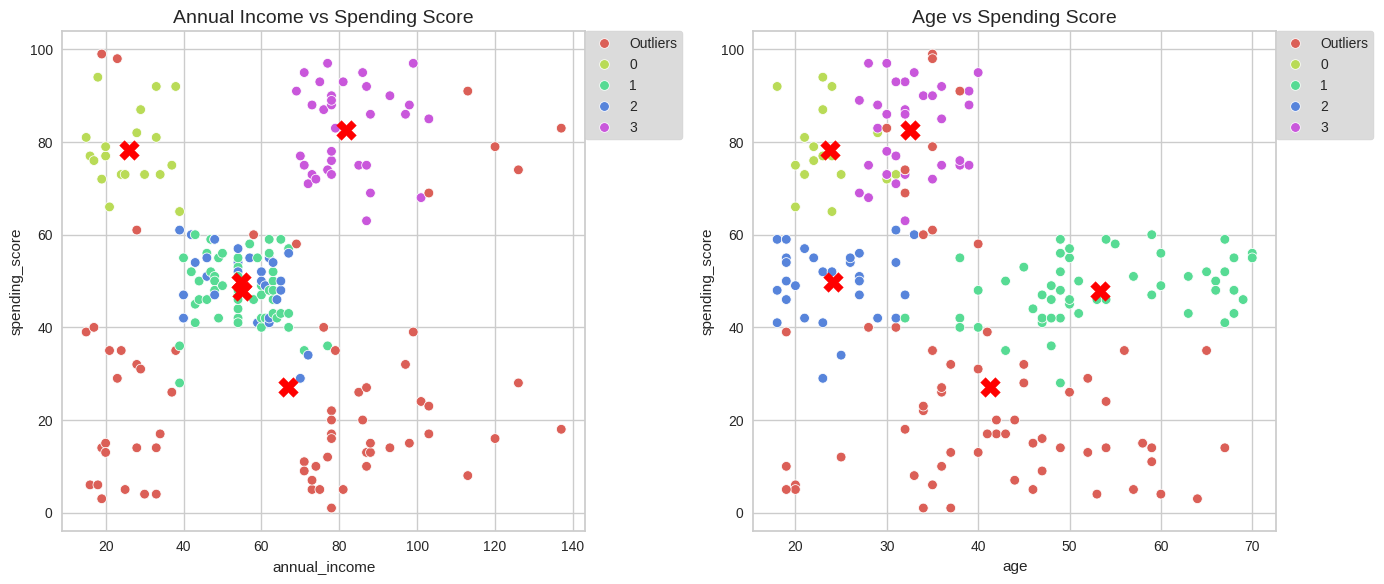

In [55]:
def plot_dbscan_clusters(df, cluster_col, k):
    df_dbscan_copy = df.copy()
    df_dbscan_copy['cluster'] = df_dbscan_copy['cluster'].astype(str).apply(lambda x: 'Outliers' if x == '-1' else x)
    centroids = df_dbscan_copy.groupby(cluster_col).mean().values

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    plot_clusters(axes[1], df_dbscan_copy, 'age', 'spending_score',
                  'Age vs Spending Score', cluster_col, dbscan, centroids[:, [0, 2]])

    plot_clusters(axes[0], df_dbscan_copy, 'annual_income', 'spending_score',
                  'Annual Income vs Spending Score', cluster_col, dbscan, centroids[:, [1, 2]])

    plt.tight_layout()
    plt.show()


plot_dbscan_clusters(df_dbscan, cluster_col='cluster', k=3)

## **5. Affinity Propagation**

Affinity Propagation is a clustering algorithm that identifies exemplars (representative data points) among the input data and forms clusters based on the similarities between these exemplars. Here’s a brief overview:

1. **Message Passing**: The algorithm works by exchanging messages between data points to indicate how well-suited one point is to serve as an exemplar for another.

2. **Input Similarity**: It requires a similarity matrix that defines how similar each pair of data points is, typically calculated using a distance metric (e.g., negative Euclidean distance).

3. **Exemplar Selection**: Each point sends two types of messages:

  - **Responsibility**: Measures how well-suited a point is to be an exemplar for another point.
  - **Availability: Indicates how likely it is that a point will be selected as an exemplar.
4. **Iterations**: These messages are updated iteratively until convergence, leading to stable responsibility and availability values.

5. **Cluster Formation**: Once the messages stabilize, each data point is assigned to the exemplar that has the highest responsibility for it, forming clusters around those exemplars.

Affinity Propagation is advantageous as it doesn’t require specifying the number of clusters beforehand and can capture complex cluster structures.

---
- **When to use:** Use when you need to identify clusters without specifying the number of clusters in advance; effective in diverse scenarios.
- **When not to use:** Not suitable for very large datasets due to memory consumption and speed limitations.

In [56]:
plot_elbow_curve(df_scaled, AffinityPropagation())

AffinityPropagation does not use a pre-defined number of clusters. Consider checking Silhouette Score instead for clustering evaluation.


In [57]:
df_aff_p = df.copy()

def affinity_propagation_cluster(X, preference_range, random_state=42):
    results = []

    for p in preference_range:
        af = AffinityPropagation(preference=p, random_state=random_state).fit(X)
        n_clusters = len(np.unique(af.labels_))

        result = {
            'preference': p,
            'clusters': n_clusters
        }

        # Only calculate scores if n_clusters > 1, else set to np.nan
        if n_clusters > 1:
            result['sil_score'] = silhouette_score(X, af.labels_)
            result['davies_bouldin_score'] = davies_bouldin_score(X, af.labels_)
            result['calinski_harabasz_score'] = calinski_harabasz_score(X, af.labels_)
        else:
            result['sil_score'] = np.nan
            result['davies_bouldin_score'] = np.nan
            result['calinski_harabasz_score'] = np.nan

        results.append(result)

    af_results = pd.DataFrame(results)
    return af_results


preference_range = range(-20000, -5000, 100)
af_results = affinity_propagation_cluster(df_aff_p, preference_range)
af_results.sort_values(by='sil_score', ascending=False).head()

preference  clusters  sil_score  davies_bouldin_score  calinski_harabasz_score
82       -11800         6   0.451649              0.754198               166.663949
27       -17300         6   0.451491              0.763119               163.315641
51       -14900         6   0.451491              0.763119               163.315641
110       -9000         6   0.451440              0.741503               166.568745
137       -6300         6   0.451440              0.741503               166.568745

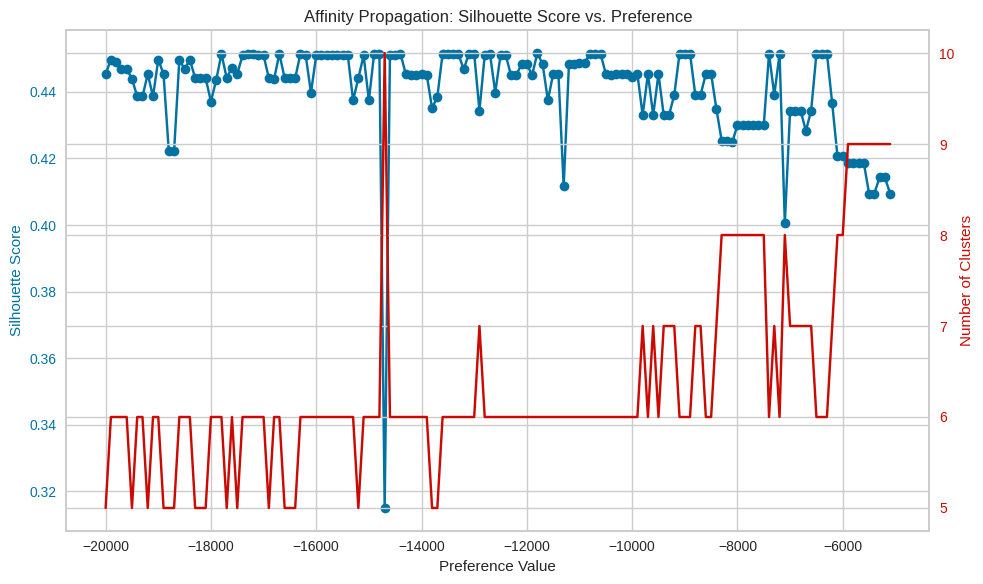

In [58]:
def plot_affinity_propagation_results(af_results):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot silhouette scores
    ax1.plot(af_results['preference'], af_results['sil_score'], color='b', label='Silhouette Score', marker='o')
    ax1.set_xlabel('Preference Value')
    ax1.set_ylabel('Silhouette Score', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('Affinity Propagation: Silhouette Score vs. Preference')

    # Plot number of clusters on the same graph with a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(af_results['preference'], af_results['clusters'], color='r', label='Number of Clusters', marker='x')
    ax2.set_ylabel('Number of Clusters', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()  # To ensure everything fits without overlap
    plt.show()


plot_affinity_propagation_results(af_results)

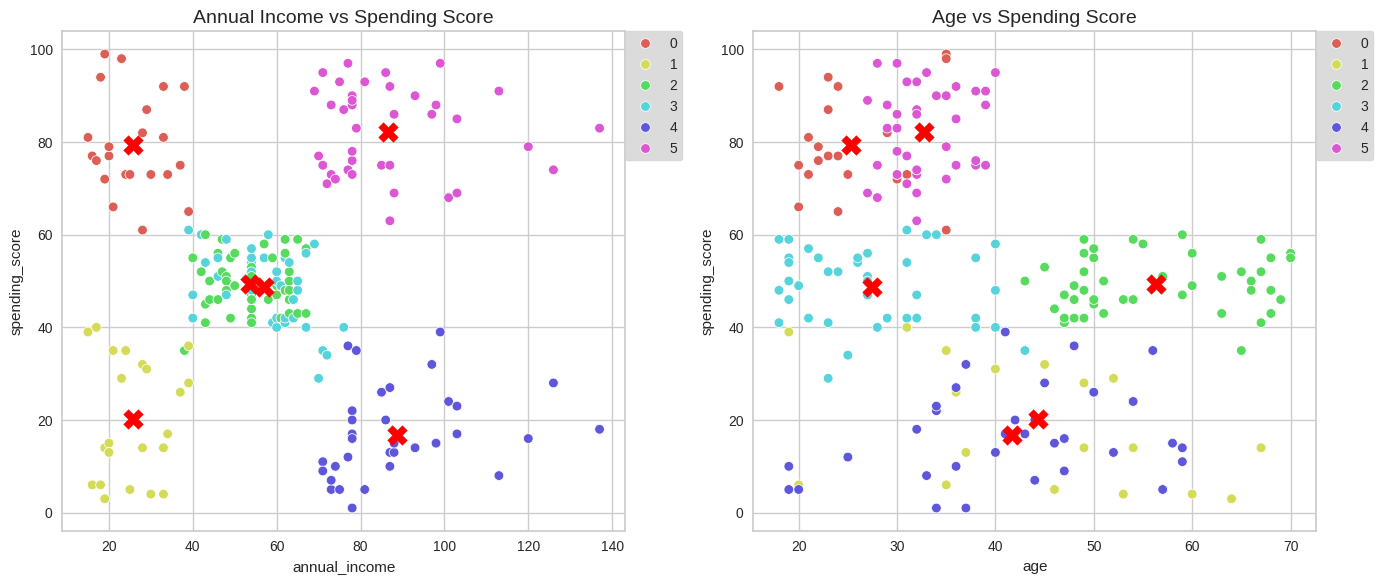

In [59]:
df_aff_p = df.copy()

aff_prop = AffinityPropagation(preference=-11800, random_state=42)
aff_prop.fit(df)

df_aff_p['cluster'] = aff_prop.labels_
centroids = df_aff_p.groupby('cluster').mean().values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_clusters(axes[0], df_aff_p, 'annual_income', 'spending_score',
                  'Annual Income vs Spending Score', 'cluster', aff_prop, centroids[:, [1, 2]])
plot_clusters(axes[1], df_aff_p, 'age', 'spending_score',
                  'Age vs Spending Score', 'cluster', aff_prop, centroids[:, [0, 2]])
plt.tight_layout()
plt.show()

## **6. Mean Shift**


Mean Shift is a non-parametric clustering algorithm that identifies clusters by finding the modes (peaks) in the density of data points. Here’s a simple overview:

1. **Initialization**: Start with a set of data points and choose a bandwidth parameter, which determines the size of the region to consider when estimating the density.

2. **Mean Shift Procedure**: For each data point, calculate the mean of all points within the bandwidth and move the point towards this mean. This step is repeated iteratively.

3. **Convergence**: The algorithm continues shifting each point until the movement is smaller than a predefined threshold, indicating convergence.

4. **Cluster Assignment**: Once the points converge, they are assigned to clusters based on their final locations, where points that converge to the same mode are grouped together.

Mean Shift is effective for finding clusters of arbitrary shapes and is particularly useful in image processing and computer vision tasks. However, it can be computationally intensive, especially with large datasets.

---
- **When to use:** Effective for finding clusters of arbitrary shape, particularly when you expect clusters to be close together.
- **When not to use:** Avoid if the bandwidth parameter is poorly chosen, as it can lead to overfitting or underfitting the data.

In [60]:
plot_elbow_curve(df_scaled, MeanShift())

MeanShift does not use a pre-defined number of clusters. Consider checking Silhouette Score instead for clustering evaluation.


In [61]:
def mean_shift_optimal_quantile(X, quantile_range, n_samples=500):
    results = []

    for quantile in quantile_range:
        bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(X)

        labels = ms.labels_
        n_clusters = len(np.unique(labels))

        result = {
            'quantile': quantile,
            'clusters': n_clusters,
            'bandwidth': bandwidth
        }

        if n_clusters > 1:  # Silhouette score requires at least 2 clusters
            result['sil_score'] = silhouette_score(X, labels)
            result['davies_bouldin_score'] = davies_bouldin_score(X, labels)
            result['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
        else:
            result['sil_score'] = np.nan
            result['davies_bouldin_score'] = np.nan
            result['calinski_harabasz_score'] = np.nan

        results.append(result)

    ms_results = pd.DataFrame(results)
    return ms_results

quantile_range = np.arange(0.05, 0.2, 0.01)
results = mean_shift_optimal_quantile(df_scaled, quantile_range)
results.sort_values(by='sil_score', ascending=False).head()

quantile  clusters  bandwidth  sil_score  davies_bouldin_score  calinski_harabasz_score
6      0.11         6   1.075264   0.419893              0.845013               133.186385
5      0.10         7   1.014914   0.418201              0.885659               117.862182
4      0.09        11   0.955976   0.406527              0.852050               117.849143
7      0.12         5   1.127071   0.406527              0.888881               123.589263
9      0.14         4   1.223690   0.397632              0.915004               121.766914

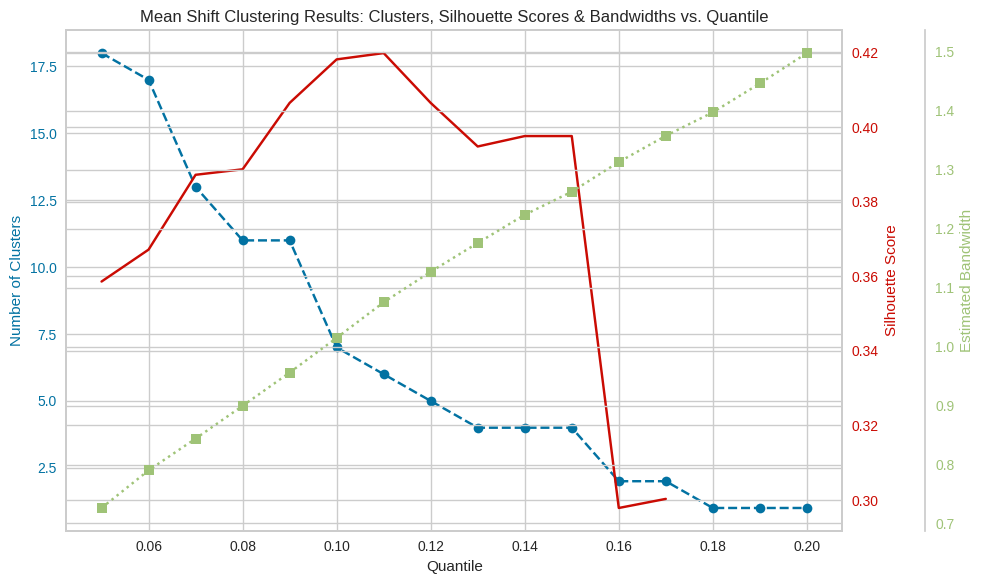

In [62]:
def plot_mean_shift_results(results):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the number of clusters on the primary y-axis
    ax1.plot(results['quantile'], results['clusters'], marker='o', linestyle='--', color='b', label='Number of Clusters')
    ax1.set_xlabel('Quantile')
    ax1.set_ylabel('Number of Clusters', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot the silhouette score on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(results['quantile'], results['sil_score'], marker='x', linestyle='-', color='r', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add a third y-axis for bandwidths (use ax3 for bandwidths)
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))  # Move the bandwidth axis outward
    ax3.plot(results['quantile'], results['bandwidth'], marker='s', linestyle=':', color='g', label='Bandwidth')
    ax3.set_ylabel('Estimated Bandwidth', color='g')
    ax3.tick_params(axis='y', labelcolor='g')

    plt.title('Mean Shift Clustering Results: Clusters, Silhouette Scores & Bandwidths vs. Quantile')
    fig.tight_layout()
    ax1.grid(True)
    plt.show()


plot_mean_shift_results(results)

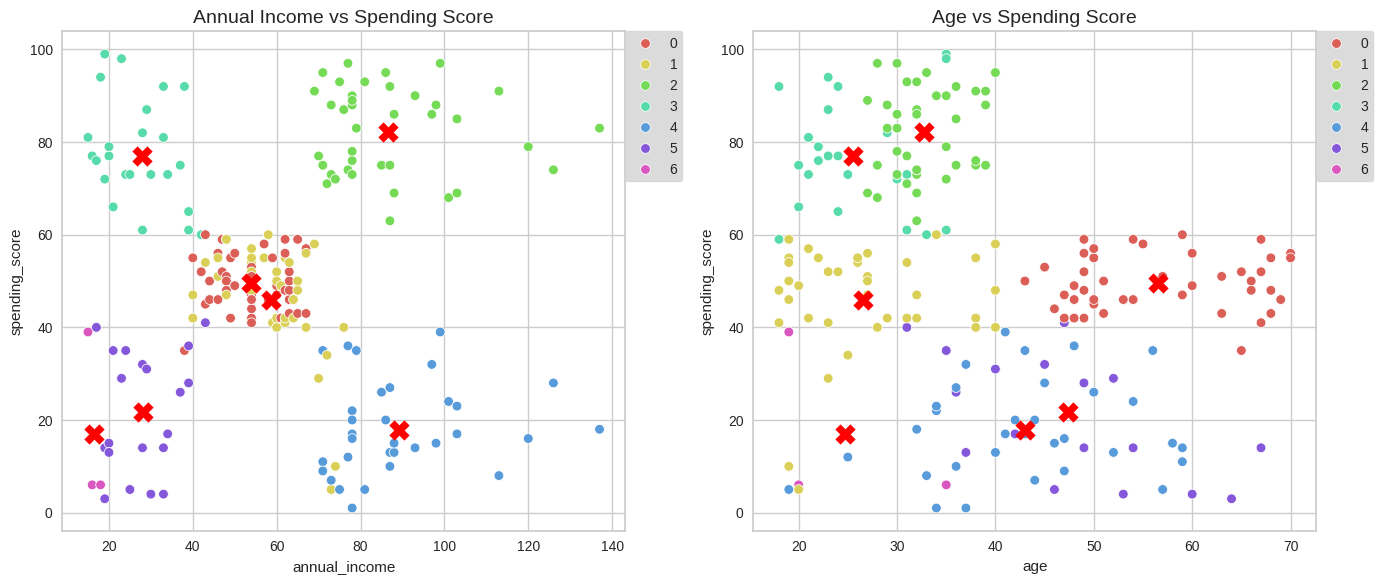

In [63]:
df_mean_shift = df.copy()

bandwidth = estimate_bandwidth(df_scaled, quantile=0.11)
ms = MeanShift(bandwidth=bandwidth)
ms.fit(df_scaled)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
df_mean_shift['cluster'] = labels
centroids = df_mean_shift.groupby('cluster').mean().values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_clusters(axes[0], df_mean_shift, 'annual_income', 'spending_score',
                  'Annual Income vs Spending Score', 'cluster', dbscan, centroids[:, [1, 2]])
plot_clusters(axes[1], df_mean_shift, 'age', 'spending_score',
                  'Age vs Spending Score', 'cluster', dbscan, centroids[:, [0, 2]])
plt.tight_layout()
plt.show()

## **7. Optics**

OPTICS (Ordering Points to Identify the Clustering Structure) is a density-based clustering algorithm that extends DBSCAN by providing a more detailed view of the data's clustering structure. Here’s a brief overview:

1. **Parameters**: Like DBSCAN, OPTICS requires two main parameters:

  - **Epsilon (ε)**: The maximum radius of the neighborhood to consider.
  - **MinPts**: The minimum number of points required to form a dense region.
2. **Reachability Distances**: Instead of a binary cluster assignment, OPTICS calculates reachability distances for each point, which measure how far a point is from its nearest core point in a cluster.

3. **Ordering Points**: Points are ordered based on their reachability distances, allowing the algorithm to capture the clustering hierarchy without explicitly forming clusters.

4. **Cluster Extraction**: Clusters can be extracted from the ordered list by defining a reachability distance threshold, which helps identify dense regions in the data.

5. **Flexibility**: This method enables the detection of clusters with varying densities and sizes, providing a more nuanced understanding of the data's structure.

OPTICS is particularly useful when dealing with complex datasets where traditional clustering methods may struggle to identify meaningful structures.

---
- **When to use:** Use when you need a robust clustering solution that can handle varying cluster densities; suitable for complex datasets with unevenly sized clusters.
- **When not to use:** Not recommended for datasets where the underlying structure is unclear, as it may produce less interpretable results compared to simpler methods.

In [64]:
plot_elbow_curve(df_scaled, OPTICS())

OPTICS does not use a pre-defined number of clusters. Consider checking Silhouette Score instead for clustering evaluation.


In [65]:
def optics_optimal_params(X, min_samples_range, eps_range):
    results = []

    for min_samples in min_samples_range:
        for eps in eps_range:
            try:
                optics = OPTICS(min_samples=min_samples, eps=eps).fit(X)

                labels = optics.labels_
                n_clusters = len(np.unique(labels[labels >= 0]))  # exclude noise points (-1 label)

                result = {
                    'min_samples': min_samples,
                    'eps': eps,
                    'clusters': n_clusters
                }

                if n_clusters > 1:
                    result['sil_score'] = silhouette_score(X, labels)
                    result['davies_bouldin_score'] = davies_bouldin_score(X, labels)
                    result['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
                else:
                    result['sil_score'] = np.nan
                    result['davies_bouldin_score'] = np.nan
                    result['calinski_harabasz_score'] = np.nan

                results.append(result)

            except ValueError as e:
                print(f"Error for min_samples={min_samples}, eps={eps}: {e}")
                results.append({
                    'min_samples': min_samples,
                    'eps': eps,
                    'clusters': -1,
                    'sil_score': np.nan,
                    'davies_bouldin_score': np.nan,
                    'calinski_harabasz_score': np.nan
                })

    optics_results = pd.DataFrame(results)
    return optics_results

min_samples_range = range(5, 20)
eps_range = np.arange(0.1, 1.0, 0.1)
optics_results = optics_optimal_params(df_scaled, min_samples_range, eps_range)
optics_results.sort_values(by='sil_score', ascending=False).head()

min_samples  eps  clusters  sil_score  davies_bouldin_score  calinski_harabasz_score
96           15  0.7         4   0.151789               1.96374                36.190479
97           15  0.8         4   0.151789               1.96374                36.190479
94           15  0.5         4   0.151789               1.96374                36.190479
91           15  0.2         4   0.151789               1.96374                36.190479
92           15  0.3         4   0.151789               1.96374                36.190479

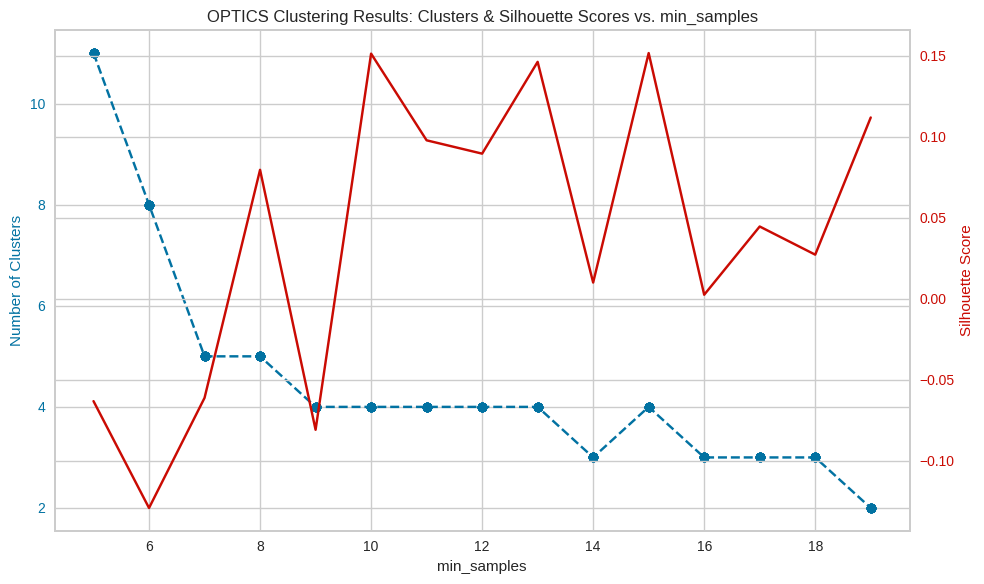

In [66]:
def plot_optics_results(results):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the number of clusters on the primary y-axis
    ax1.plot(results['min_samples'], results['clusters'], marker='o', linestyle='--', color='b', label='Number of Clusters')
    ax1.set_xlabel('min_samples')
    ax1.set_ylabel('Number of Clusters', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot the silhouette score on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(results['min_samples'], results['sil_score'], marker='x', linestyle='-', color='r', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('OPTICS Clustering Results: Clusters & Silhouette Scores vs. min_samples')
    fig.tight_layout()
    ax1.grid(True)
    plt.show()


plot_optics_results(optics_results)

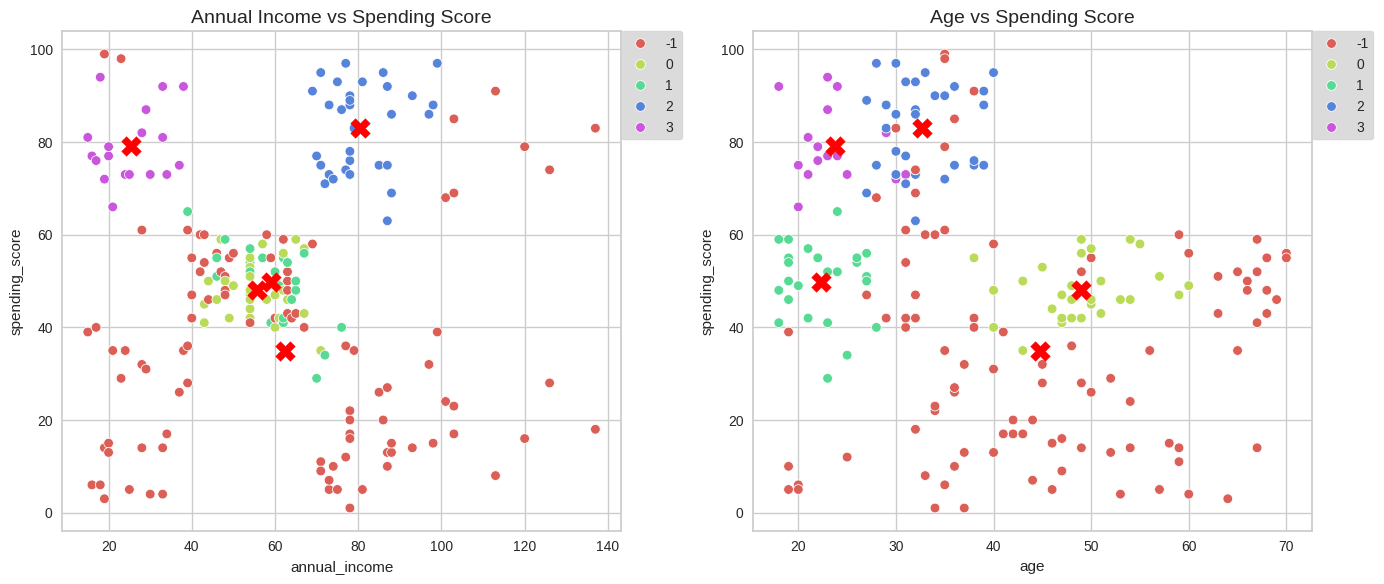

In [67]:
optics = OPTICS(min_samples=15, eps=0.8)
optics.fit(df_scaled)

labels = optics.labels_
df_optics = df.copy()
df_optics['cluster'] = labels
centroids = df_optics.groupby('cluster').mean().values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_clusters(axes[0], df_optics, 'annual_income', 'spending_score',
                  'Annual Income vs Spending Score', 'cluster', optics, centroids[:, [1, 2]])
plot_clusters(axes[1], df_optics, 'age', 'spending_score',
                  'Age vs Spending Score', 'cluster', optics, centroids[:, [0, 2]])
plt.tight_layout()
plt.show()

# **IV. Conclusion**

In [68]:
data_models_dict = {
    "KMeans 4 Clusters": {"data": df_kmeans_4_cl, "model": kmeans_4},
    # "KMeans 6 Clusters": {"data": df_kmeans_6_cl, "model": kmeans_6},
    # "KMeans 4 Clusters PCA": {"data": df_kmeans_4_pca, "model": kmeans_4_pca},
    "KMeans 2 Clusters PCA": {"data": df_kmeans_2_pca, "model": kmeans_2_pca},
    "Hierarchical Clustering": {"data": df_hier_clus, "model": None},
    "DBSCAN": {"data": df_dbscan, "model": dbscan},
    "Affinity Propagation": {"data": df_aff_p, "model": aff_prop},
    "Mean Shift": {"data": df_mean_shift, "model": ms},
    "OPTICS": {"data": df_optics, "model": optics}
}

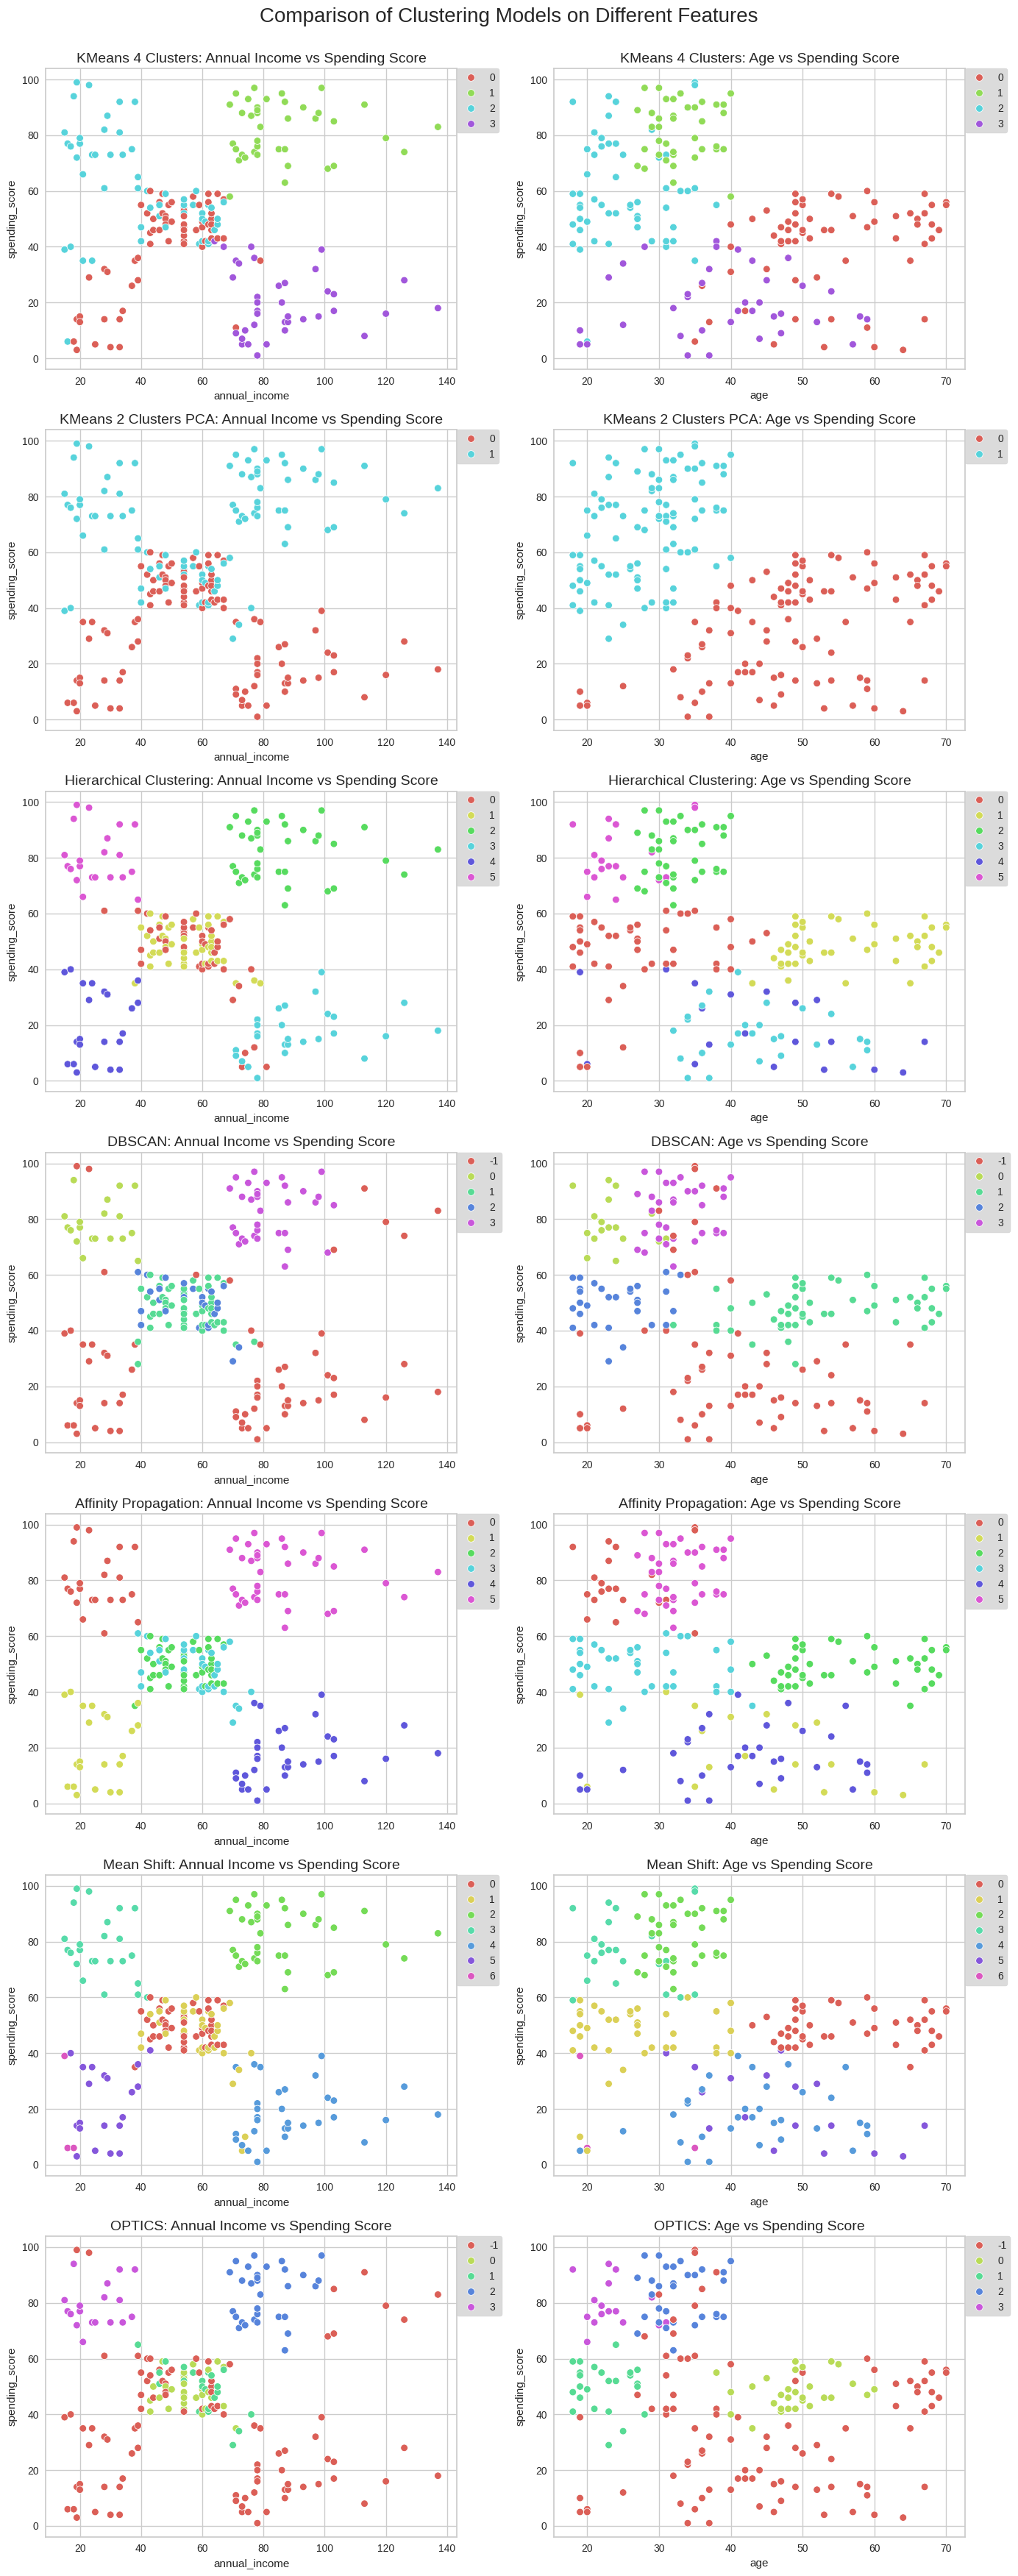

In [69]:
def compare_models(data_models_dict):
    fig, axes = plt.subplots(len(data_models_dict), 2, figsize=(14, 5 * len(data_models_dict)))

    for i, (model_name, model_info) in enumerate(data_models_dict.items()):
        data = model_info['data']
        model = model_info['model']
        centroids = None

        plot_clusters(ax=axes[i, 0], model=model, data=data, x='annual_income', y='spending_score',
                      centroids=centroids, title=f"{model_name}: Annual Income vs Spending Score", cluster_col='cluster')

        plot_clusters(ax=axes[i, 1], model=model, data=data, x='age', y='spending_score',
                      centroids=centroids, title=f"{model_name}: Age vs Spending Score", cluster_col='cluster')
    plt.suptitle('Comparison of Clustering Models on Different Features', fontsize=20, y=1)
    plt.tight_layout()
    plt.show()


compare_models(data_models_dict)

In [70]:
cluster_scores = {
    'Silhouette Score': [],
    'Davies-Bouldin Index': [],
    'Calinski-Harabasz Score': []
}

model_names = []

for model_name, model_data in data_models_dict.items():
    df = model_data['data']
    model = model_data['model']

    if 'cluster' in df.columns:
        X = df.drop(columns='cluster')
        labels = df['cluster']

        try:
            silhouette = silhouette_score(X, labels)
        except Exception as e:
            silhouette = None

        try:
            davies_bouldin = davies_bouldin_score(X, labels)
        except Exception as e:
            davies_bouldin = None

        try:
            calinski_harabasz = calinski_harabasz_score(X, labels)
        except Exception as e:
            calinski_harabasz = None

        cluster_scores['Silhouette Score'].append(silhouette)
        cluster_scores['Davies-Bouldin Index'].append(davies_bouldin)
        cluster_scores['Calinski-Harabasz Score'].append(calinski_harabasz)

        model_names.append(model_name)

scores_df = pd.DataFrame(cluster_scores, index=model_names)
scores_df

Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
KMeans 4 Clusters                0.382594              1.051159               121.058420
KMeans 2 Clusters PCA            0.276258              1.442515                80.994109
Hierarchical Clustering          0.430749              0.834040               147.029982
DBSCAN                           0.278400              1.503953                47.179399
Affinity Propagation             0.451649              0.754198               166.663949
Mean Shift                       0.421384              0.921363               134.078419
OPTICS                           0.140719              1.968391                33.887432

In [71]:
def concat_cluster_value_counts(data_models_dict):
    value_counts_list = []

    for model_name, model_info in data_models_dict.items():
        data = model_info['data']
        cluster_value_counts = data['cluster'].value_counts().sort_index()

        cluster_df = pd.DataFrame(cluster_value_counts)
        cluster_df.columns = [f"{model_name.replace(' ', '_')}"]
        value_counts_list.append(cluster_df)

    combined_df = pd.concat(value_counts_list, axis=1)
    combined_df = combined_df.sort_index().replace(np.nan, "-")

    return combined_df

result_df = concat_cluster_value_counts(data_models_dict)
result_df

KMeans_4_Clusters KMeans_2_Clusters_PCA Hierarchical_Clustering DBSCAN Affinity_Propagation Mean_Shift OPTICS
cluster                                                                                                              
-1                      -                     -                       -   65.0                    -          -   97.0
 0                   65.0                 103.0                    45.0   19.0                 22.0       43.0   29.0
 1                   40.0                  97.0                    45.0   53.0                 22.0       37.0   24.0
 2                   57.0                     -                    39.0   29.0                 44.0       39.0   32.0
 3                   38.0                     -                    28.0   34.0                 39.0       25.0   18.0
 4                      -                     -                    22.0      -                 34.0       33.0      -
 5                      -                     -                    21.0      -                 39.0       20.0      -
 6                      -                     -                       -      -                    -        3.0      -

In [72]:
combined_grouped_stats = []

for model_name, model_data in data_models_dict.items():
    df = model_data['data']
    if 'cluster' in df.columns:
        grouped_stats = df.groupby('cluster').agg(['count', 'mean', 'median', 'std'])

        grouped_stats_rounded = grouped_stats.round(2)
        grouped_stats_rounded.index = pd.MultiIndex.from_product([[model_name], grouped_stats_rounded.index])
        combined_grouped_stats.append(grouped_stats_rounded)

final_grouped_combined_df = pd.concat(combined_grouped_stats)
final_grouped_combined_df.T

KMeans 4 Clusters                      KMeans 2 Clusters PCA        Hierarchical Clustering                                    DBSCAN                             Affinity Propagation                                    Mean Shift                                           OPTICS                            
cluster                               0      1      2      3                     0      1                       0      1      2      3      4      5     -1      0      1      2      3                    0      1      2      3      4      5          0      1      2      3      4      5      6     -1      0      1      2      3
age            count              65.00  40.00  57.00  38.00                103.00  97.00                   45.00  45.00  39.00  28.00  22.00  21.00  65.00  19.00  53.00  29.00  34.00                22.00  22.00  44.00  39.00  34.00  39.00      43.00  37.00  39.00  25.00  33.00  20.00   3.00  97.00  29.00  24.00  32.00  18.00
               mean               53.98  32.88  25.44  39.37                 48.73  28.36                   27.38  56.40  32.69  43.89  44.32  24.81  41.31  23.74  53.36  24.07  32.59                25.27  44.32  56.34  27.41  41.65  32.69      56.56  26.57  32.69  25.52  43.03  47.40  24.67  44.77  48.97  22.33  32.62  23.72
               median             52.00  32.00  24.00  40.50                 49.00  29.00                   26.00  54.00  32.00  43.50  45.50  23.00  40.00  23.00  50.00  23.00  32.00                23.50  45.50  54.00  27.00  42.50  32.00      54.00  26.00  32.00  24.00  43.00  47.50  20.00  42.00  49.00  22.50  32.00  23.00
               std                 9.42   3.86   5.71  10.62                 11.93   6.11                    7.76   8.37   3.73   8.34  12.80   4.91  11.72   3.74   9.91   4.77   3.84                 5.26  12.80   8.55   7.40  11.06   3.73       8.53   7.08   3.73   5.49   9.67  10.10   8.96  13.99   5.32   3.36   3.82   3.85
annual_income  count              65.00  40.00  57.00  38.00                103.00  97.00                   45.00  45.00  39.00  28.00  22.00  21.00  65.00  19.00  53.00  29.00  34.00                22.00  22.00  44.00  39.00  34.00  39.00      43.00  37.00  39.00  25.00  33.00  20.00   3.00  97.00  29.00  24.00  32.00  18.00
               mean               47.71  86.10  40.00  86.50                 60.50  60.63                   57.51  55.29  86.54  91.29  25.77  25.62  66.75  26.11  54.91  54.86  81.65                25.73  25.77  53.70  57.03  88.74  86.54      53.95  58.68  86.54  27.80  89.12  28.05  16.33  62.41  55.69  58.92  80.38  25.39
               median             49.00  78.50  40.00  79.50                 60.00  62.00                   60.00  54.00  79.00  87.00  24.50  24.00  76.00  25.00  54.00  57.00  78.00                24.50  24.50  54.00  60.00  85.50  79.00      54.00  60.00  79.00  28.00  86.00  28.00  16.00  63.00  54.00  60.50  78.00  24.50
               std                14.65  16.34  17.03  16.76                 25.22  27.46                   11.75   9.83  16.31  16.92   7.65   7.74  36.05   7.96   9.02  10.02   9.70                 7.57   7.65   8.24  10.04  16.33  16.31       8.17   9.78  16.31   9.20  16.44   7.78   1.53  31.41   7.53   8.96   8.47   7.54
spending_score count              65.00  40.00  57.00  38.00                103.00  97.00                   45.00  45.00  39.00  28.00  22.00  21.00  65.00  19.00  53.00  29.00  34.00                22.00  22.00  44.00  39.00  34.00  39.00      43.00  37.00  39.00  25.00  33.00  20.00   3.00  97.00  29.00  24.00  32.00  18.00
               mean               39.97  81.53  60.30  19.58                 32.18  69.33                   45.84  48.36  82.13  16.68  20.27  80.24  27.12  78.32  47.92  49.72  82.56                79.36  20.27  49.39  48.77  16.76  82.13      49.58  46.00  82.13  77.04  17.88  21.80  17.00  34.79  48.07  49.75  82.94  79.06
               median             46.00  83.00  56.00  17.00                 35.00  73

1. **KMeans Clustering (4 Clusters):**

  - **Count and Stability**: This approach yielded a balanced distribution across the clusters, especially for the 'Age' metric, indicating that it can effectively identify distinct groups within the data.
  - **Mean Values**: The average 'Age' across clusters shows a variation, suggesting that KMeans captures age differences well. The average 'Annual Income' also indicates a clear segmentation based on financial data.
  - **Standard Deviation**: The relatively low standard deviation for 'Age' indicates that the values are closely clustered around the mean, providing a more stable clustering solution.

2. **KMeans Clustering with PCA (2 Clusters):**

  - **Reduction in Complexity:** This approach simplifies the dataset by reducing the number of clusters, which may lead to less granularity. However, it captures essential patterns effectively, as seen in the income metrics.
  - **Mean and Median Comparison**: The mean and median values are relatively consistent, suggesting that PCA has not significantly distorted the data representation.

3. **Hierarchical Clustering**:

  - **Cluster Flexibility**: This method allows for a more flexible approach to defining clusters, which can be advantageous in exploratory data analysis. The distribution of counts suggests that it may identify clusters with varying densities.
  - **Performance in Metrics**: While it provides insights into 'Age' distribution, it shows a higher count of low-income segments across several clusters, indicating a more nuanced understanding of income stratification.

4. **DBSCAN**:

  - **Density-Based Clustering**: DBSCAN excels in identifying noise and irregular clusters, which is reflected in the presence of the '-1' label, denoting noise points. The count of points in clusters indicates that this method is effective in highlighting density differences.
  - **Mean Values**: The average metrics suggest it identifies clusters with more variation in both 'Age' and 'Annual Income,' which could be valuable in detecting outliers.

5. **Affinity Propagation**:

  - **Similar Distribution**: This algorithm generates a similar count of clusters to KMeans, indicating that it can capture similar structures in the data. The metrics show a broad spread, particularly in 'Annual Income,' suggesting it recognizes various income brackets effectively.
  - **Distinct Cluster Profiles**: The variation in means across clusters indicates its capability to delineate different customer profiles based on 'Age' and 'Income.'

6. **Mean Shift**:

  - **Adaptive Clustering**: Mean Shift identifies clusters by locating the densest regions of data points, making it robust to noise and allowing for natural cluster shapes without predefined parameters.
  - **Distribution of Metrics**: The mean and median values indicate stability in identifying core clusters. However, there may be some overlap in 'Annual Income,' suggesting a potential challenge in distinguishing between closely related clusters.

7. **OPTICS**:

  - **Hierarchical and Density Awareness**: Similar to DBSCAN but more robust, OPTICS maintains awareness of cluster structure. The counts reflect a nuanced detection of clusters without imposing a strict number.
  - **Interpretation of Results**: The wide range of values across clusters suggests that it captures intricate patterns in the dataset, although interpretation may be complex due to the overlap in metrics.

## **Summary**
In summary, the choice of clustering algorithm significantly impacts the results, with each algorithm offering unique strengths:

- **KMeans** provides clear, stable clusters and is efficient for large datasets.
- **Hierarchical Clustering** and **Affinity Propagation** offer flexible insights into cluster structures.
- **DBSCAN** and **OPTICS** are effective for identifying density-based clusters and outliers, making them suitable for datasets with noise.
- **Mean Shift** adaptively identifies clusters based on data density, revealing core structures while accounting for overlapping distributions.

Ultimately, the optimal choice of algorithm depends on the specific goals of the analysis, the data characteristics, and the desired granularity of the results. Combining insights from multiple algorithms may also yield a comprehensive understanding of the data structure.